### Import libraries

In [1]:
from typing import List, Dict
import inspect
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import io
import sys
import pickle
import itertools
import datetime
import copy
from typing import Dict, Tuple, List
from tqdm import tqdm
import random
import csv
import json
import tifffile
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statistics
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.neighbors
import sklearn.preprocessing
from IPython.display import display, HTML

# Save results to Excel and HTML
import base64
import urllib

import networkx as nx
from networkx.algorithms import bipartite

import torch_geometric
import torch_geometric.transforms as T
import torch_geometric.transforms
import torch_geometric.datasets
import torch_geometric.nn
from torch_geometric.utils import to_networkx

import torch
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn

import warnings

warnings.filterwarnings('ignore', module='sklearn')

Comment functions in python the proper way:
https://stackoverflow.com/questions/2357230/what-is-the-proper-way-to-comment-functions-in-python
```python
def test_function(p1, p2, p3):
    """
    test_function does blah blah blah.

    :param p1: describe about parameter p1
    :param p2: describe about parameter p2
    :param p3: describe about parameter p3
    :return: describe what it returns
    """ 
    pass
```

In [2]:
###################################################
### Define int encodings for string variables #####
###################################################

#nodes type encodings
nodes_type_int_encodings = {
    "nuclei":0,
    "golgi":1
}

reversed_nodes_type_int_encodings = {v: k for k, v in nodes_type_int_encodings.items()}

#edges type encodings
edges_type_int_encodings = {
    "nuclei-nuclei":0,
    "golgi-golgi":1,
    "golgi-nuclei":2,
    "nuclei-golgi":3
}

reversed_edges_type_int_encodings = {v: k for k, v in edges_type_int_encodings.items()}

In [3]:
class CustomEncoder(json.JSONEncoder):
    """
    Custom JSON encoder for data types that are not JSON serializable.
    See here for more info: https://stackoverflow.com/questions/50916422/python-typeerror-object-of-type-int64-is-not-json-serializable
    Usage: 
    
    with open("out.json", "w") as outfile:
        json.dump(content, outfile, cls = CustomEncoder)
        
    """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        if isinstance(obj, torch.Tensor):
            return obj.cpu().numpy()
        return super(CustomEncoder, self).default(obj)

In [4]:
###########################################################
################ Synthetic Graphs #########################
###########################################################

def generate_random_walk_1D(number_of_points, dims = 1, n_runs = 1, fig_path = None, step_set = [-1, 0, 1]):
    assert number_of_points>1
    # Define parameters for the walk
    step_n = number_of_points - 1 #number of points-1 because it doesn't count the origin
    origin = np.zeros((1,dims))
    # Simulate steps in 1D
    step_shape = (step_n,dims)
    steps = np.random.choice(a=step_set, size=step_shape)
    path = np.concatenate([origin, steps]).cumsum(0)
    return path
    
def plot_1D_path(path):
    number_of_points = len(path)
    step_n = number_of_points - 1
    start = path[:1]
    stop = path[-1:]
    # Plot the path
    fig = plt.figure(figsize=(8,4),dpi=200)
    ax = fig.add_subplot(111)
    ax.scatter(np.arange(step_n+1), path, c="blue",alpha=0.25,s=0.05);
    ax.plot(path,c="blue",alpha=0.5,lw=0.5,ls="-",);
    ax.plot(0, start, c="red", marker="+")
    ax.plot(step_n, stop, c="black", marker="o")
    plt.title("1D Random Walk")
    plt.tight_layout(pad=0)
    return fig

def generate_random_walk_2D(number_of_points, dims = 2, n_runs = 1, fig_path = None, step_set = [-1, 0 ,1]):
    """
    :param number_of_points: number of points in the random walk
    :param dims: number of dimensions of the points
    :param number_of_points: number of points in the random walk
    :param fig_path: path to save the figure to
    :return path: random walk np.array
    """
    assert (number_of_points>1) #is even because it is nuclei-golgi pair
    step_n = number_of_points - 1 #number of points-1 because it doesn't count the origin

    runs = np.arange(n_runs)
    step_shape = (step_n,dims)

    origin = np.zeros((1,dims))
    # Simulate steps in 2D
    
    steps = np.random.choice(a=step_set, size=step_shape)
    path = np.concatenate([origin, steps]).cumsum(0)
    return path

def plot_2D_path(path):
    start = path[:1]
    stop = path[-1:]
    # Plot the path
    fig = plt.figure(figsize=(8,8),dpi=200)
    ax = fig.add_subplot(111)
    ax.scatter(path[:,0], path[:,1],c="blue",alpha=0.25,s=0.05);
    ax.plot(path[:,0], path[:,1],c="blue",alpha=0.5,lw=0.25,ls="-");
    ax.plot(start[:,0], start[:,1],c="red", marker="+")
    ax.plot(stop[:,0], stop[:,1],c="black", marker="o")
    plt.title("2D Random Walk")
    plt.tight_layout(pad=0)
    return fig

def generate_random_walk_3D(number_of_points, dims = 3, n_runs = 1, fig_path = None):
    """
    :param number_of_points: number of points in the random walk
    :param dims: number of dimensions of the points
    :param number_of_points: number of points in the random walk
    :param fig_path: path to save the figure to
    :return path: random walk np.array
    """
    assert (number_of_points>1) #is even because it is nuclei-golgi pair
    step_n = number_of_points - 1 #number of points-1 because it doesn't count the origin

    step_set = [-1, 0 ,1]
    runs = np.arange(n_runs)
    step_shape = (step_n,dims)

    # Simulate steps in 3D
    origin = np.random.randint(low=-10,high=10,size=(1,dims))
    steps = np.random.choice(a=step_set, size=step_shape)
    path = np.concatenate([origin, steps]).cumsum(0)
    
    return path

def plot_3D_path(path):
    # Plot
    fig = plt.figure(figsize=(10,10),dpi=250)
    ax = fig.add_subplot(111, projection="3d")
    ax.grid(False)
    ax.xaxis.pane.fill = ax.yaxis.pane.fill = ax.zaxis.pane.fill = False
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    
    col = colors.__next__()#define the color
    
    start = path[:1]
    stop = path[-1:]
    # Plot the path
    ax.scatter3D(path[:,0], path[:,1], path[:,2],
                 c=col,alpha=0.15,s=1);
    ax.plot3D(path[:,0], path[:,1], path[:,2], 
              c=col, alpha=0.25,lw=0.25)
    ax.plot3D(start[:,0], start[:,1], start[:,2],
              c=col, marker="+")
    ax.plot3D(stop[:,0], stop[:,1], stop[:,2],
              c=col, marker="o");
    return fig

def plot_3D_path_beautiful(path, nuclei_color="red", golgi_color="green"):
    # Create a figure and 3D axes
    fig = plt.figure(figsize=(10, 10), dpi=250)
    ax = fig.add_subplot(111, projection="3d")
    ax.grid(False)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z", labelpad=0, fontsize=12, x=0.95, y=0.9)

    
    # Plot nuclei and golgi points with lines
    for i in range(len(path) - 1):
        # Determine the linestyle based on even or odd index
        linestyle = "-"
        line_color = "blue"  # Default line color for non-dashed lines
        if i % 2 == 1:
            linestyle = "--"
            line_color = "lightblue"  # Light blue for dashed lines

        # Plot points
        marker = "o" if i % 2 == 0 else "^"  # Set markers for nuclei and golgi
        ax.scatter3D(path[i, 0], path[i, 1], path[i, 2], c=nuclei_color if i % 2 == 0 else golgi_color, marker=marker, s=30)
        ax.plot3D([path[i, 0], path[i + 1, 0]],
                  [path[i, 1], path[i + 1, 1]],
                  [path[i, 2], path[i + 1, 2]], linestyle, c=line_color, alpha=0.5, lw=1)  # Set line color

    # Plot the last point
    ax.scatter3D(path[-1, 0], path[-1, 1], path[-1, 2], c=golgi_color, marker="^", s=30)

    # Add a manual legend
    custom_legend = [
        plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=nuclei_color, markersize=8, label="Nuclei"),
        plt.Line2D([0], [0], marker="^", color="w", markerfacecolor=golgi_color, markersize=8, label="Golgi"),
        plt.Line2D([0], [0], linestyle="-", color="blue", label="Nuclei-Golgi Connection")
    ]
    ax.legend(handles=custom_legend, loc="upper right")

    return fig

def calculate_golgi_coords(nuclei_i, nuclei_j, proximity_factor, deviation_factor):
    difference_vector = np.subtract(nuclei_j, nuclei_i)
    
    # Introduce a perturbation based on deviation_factor
    perturbation = np.random.uniform(-deviation_factor, deviation_factor, size=difference_vector.shape)
    
    return np.add(nuclei_i, (difference_vector + perturbation) * proximity_factor)

# Nuclei are a 3D random walk, Golgi are in the direction of the next nuclei and near it
def generate_nuclei_golgi_3D(number_of_points, proximity_factor_range=[0.15, 0.3], deviation_factor_range=[0.05, 0.2], generation_type="random_walk_2D_z_normal_distribution"):
    assert number_of_points % 2 == 0

    if generation_type == "random_walk_3D":
        nuclei_path_3D = generate_random_walk_3D(int(number_of_points / 2) + 1, dims=3, n_runs=1, fig_path=None)
    elif generation_type == "random_walk_2D_z_normal_distribution":
        nuclei_path_2D = generate_random_walk_2D(int(number_of_points / 2) + 1, dims=2, n_runs=1, fig_path=None)
        z_dimension_path = np.random.normal(0, 1, int(number_of_points / 2) + 1).reshape(int(number_of_points / 2) + 1, 1)
        nuclei_path_3D = np.hstack((nuclei_path_2D, z_dimension_path))
    elif generation_type == "random_walk_1D_y_fixed_z_normal_distribution":
        nuclei_path_1D = generate_random_walk_1D(int(number_of_points / 2) + 1, dims = 1, n_runs = 1, fig_path = None)
        y_dimension_path = np.zeros((int(number_of_points / 2) + 1, 1))
        z_dimension_path = np.random.normal(0, 1, int(number_of_points / 2) + 1).reshape(int(number_of_points / 2) + 1, 1)
        nuclei_path_3D = np.hstack((nuclei_path_1D, y_dimension_path, z_dimension_path))
    elif generation_type == "random_walk_1D_y_fixed_z_fixed":
        nuclei_path_1D_x = generate_random_walk_1D(int(number_of_points / 2) + 1, dims = 1, n_runs = 1, fig_path = None)
        y_dimension_path = np.zeros((int(number_of_points / 2) + 1, 1))
        z_dimension_path = np.zeros((int(number_of_points / 2) + 1, 1))
        nuclei_path_3D = np.hstack((nuclei_path_1D_x, y_dimension_path, z_dimension_path))
    elif generation_type=="lin_1D_y_random_walk_z_fixed":
        nuclei_path_1D_x = np.expand_dims(np.linspace(0, number_of_points, num = int(number_of_points / 2) + 1), axis = 1)
        y_dimension_path = generate_random_walk_1D(int(number_of_points / 2) + 1, dims = 1, n_runs = 1, fig_path = None)
        z_dimension_path = np.zeros((int(number_of_points / 2) + 1, 1))
        nuclei_path_3D = np.hstack((nuclei_path_1D_x, y_dimension_path, z_dimension_path))
    elif generation_type=="lin_1D_y_fixed_z_fixed":
        nuclei_path_1D_x = np.expand_dims(np.linspace(0, number_of_points, num = int(number_of_points / 2) + 1), axis = 1)
        y_dimension_path = np.zeros((int(number_of_points / 2) + 1, 1))
        z_dimension_path = np.zeros((int(number_of_points / 2) + 1, 1))
        nuclei_path_3D = np.hstack((nuclei_path_1D_x, y_dimension_path, z_dimension_path))
        
    # Create the final path
    path_3D = [0] * number_of_points

    # Fill the nuclei first
    for i in range(0, len(path_3D), 2):
        if (i % 2 == 0):
            path_3D[i] = nuclei_path_3D[int(i / 2)]

    # Fill the golgi
    for i in range(1, len(path_3D), 2):
        if (i % 2 != 0):
            nuclei_i_pos = int(i / 2)
            nuclei_j_pos = int(i / 2) + 1
            nuclei_i = nuclei_path_3D[nuclei_i_pos]
            nuclei_j = nuclei_path_3D[nuclei_j_pos]
            
            # Randomly choose proximity_factor and deviation_factor within specified ranges
            proximity_factor = np.random.uniform(proximity_factor_range[0], proximity_factor_range[1])
            deviation_factor = np.random.uniform(deviation_factor_range[0], deviation_factor_range[1])
            
            path_3D[i] = calculate_golgi_coords(nuclei_i, nuclei_j, proximity_factor, deviation_factor)

    path_3D = np.vstack(path_3D)

    return path_3D

In [5]:
class GraphInfo:
    def __init__(self, 
                 raw_df, 
                 nodes_df, edges_df,
                 normalized_nodes_df, normalized_edges_df, edges_df_knn,
                 graph_id = None, k_inter = None, k_intra = None):
        
        self.graph_id = graph_id
        self.k_inter = k_inter
        self.k_intra = k_intra
        
        self.raw_df = raw_df
        
        self.nodes_df_original = nodes_df
        self.edges_df_original = edges_df
        
        self.nodes_df = normalized_nodes_df
        self.edges_df = normalized_edges_df
        self.edges_df_knn = edges_df_knn
        
        self.concat_nodes_edges_df = apply_concat_nodes_edges_df(nodes_df, edges_df_knn)
        
        self.pyg_graph = pyg_load_graph_from_df(nodes_df, edges_df_knn, to_undirected = False, graph_type = "homo",
                             node_feats_cols_to_remove = ["ID"], edge_feats_cols_to_remove = ["source","target","edge_label"],
                            encoder = pyg_IdentityEncoder())
        
        self.pyg_graph_edge_list, self.pyg_graph_true_labels, self.edge_list, self.edge_list_knn = [], np.array([]), [], []
        self.pyg_graph_edge_list = self.edge_index_to_edge_list(self.pyg_graph.edge_index)
        self.pyg_graph_true_labels = self.pyg_graph.edge_label.detach().cpu().numpy()
        self.edge_list = nx_convert_edges_df_to_list(self.edges_df)
        self.edge_list_knn = nx_convert_edges_df_to_list(edges_df_knn)
        
        self.node_list = nx_convert_nodes_df_to_list(self.nodes_df)
        
        #Commented because of empty edges_df for automatic graphs
        self.sklearn_graph = {}
        self.sklearn_graph["X_TRUE"], self.sklearn_graph["Y_TRUE"], self.sklearn_graph["X_KNN"], self.sklearn_graph["Y_KNN"] = sklearn_dataset_to_pytorch(self, shuffle = True)
    
    @staticmethod
    def edge_index_to_edge_list(edge_index):
        """
        Convert PyTorch Geometric edge_index tensor to NetworkX edge_list format.

        Args:
            edge_index (torch.Tensor): Edge index tensor (2 x num_edges) in PyTorch Geometric format.
            num_nodes (int): Number of nodes in the graph.

        Returns:
            list: List of edges in NetworkX edge_list format.
        """
        edge_list = edge_index.t().tolist()  # Transpose edge_index and convert to list
        return edge_list
    
    @staticmethod
    def edge_list_to_edge_df(edge_list):
        data_list = []
        for edge in edge_list:
            data_list.append({"source":edge[0], "target":edge[1], "edge_label":1})
        edges_df = pd.DataFrame(data_list) 
        return edges_df
    
    @staticmethod
    def convert_edge_pred_to_label(true, pred):
        label_mapping = {
            (1, 1): "tp",
            (1, 0): "fn",
            (0, 1): "fp",
            (0, 0): "tn"
        }
        return label_mapping[(true, pred)]

    @staticmethod
    def convert_edge_preds_to_labels(true_labels, pred_labels):
        """
        Converts edge predicted output (0 or 1) to tp,fp,tn,fn

        Args:
            pred_labels (list): List of predicted edge labels (0 or 1) corresponding to each edge.
            true_labels (list): List of true edge labels (0 or 1) corresponding to each edge.

        Returns:
            pred_labels_list (list) : List of strings with "tp", "fp", "tn", "fn"
        """
        pred_labels_list = []
        
        for i, (true, pred) in enumerate(zip(true_labels, pred_labels)):
            
            label = GraphInfo.convert_edge_pred_to_label(true, pred)
            pred_labels_list.append(label)
        
        return pred_labels_list
    
    @staticmethod
    def plot_graph_nx_matplotlib(node_list, edge_list, edge_labels, ax, dims = 2, 
        plot_edges = True, 
        plot_styles = {
            "nuclei":{"marker":"o","color":"red", "alpha":0.3},
            "golgi":{"marker":"o","color":"green", "alpha":0.3},
            "tp": {"color": "black",  "dashed": False, "alpha":1},
            "fp": {"color": "yellow", "dashed": False, "alpha":1},
            "tn": None,
            "fn": {"color": "blue",  "dashed": True, "alpha":1}
        }, reversed_nodes_type_int_encodings = reversed_nodes_type_int_encodings):
        
        assert (len(edge_list)==len(edge_labels))
        dims_allowed_values = [2,3]
        if dims not in dims_allowed_values:
            raise ValueError("Wrong dims! Allowed values", str(dims_allowed_values))
        
        node_pos = {}
        # Draw nodes
        for node in node_list:
            node_id = node[0]
            node_info = node[1]
            node_type = reversed_nodes_type_int_encodings[node_info["node_type"]]
            node_color = plot_styles[node_type]["color"]#node_info["color"]
            node_alpha = plot_styles[node_type]["alpha"]
            marker = plot_styles[node_type]["marker"]
            node_size = 30#node_info["size"]
            pos = (node_info["X"], node_info["Y"], node_info["Z"])#node_info["coordinates"]#node_pos_list[node_id]
            node_pos[node_id] = pos
            
            if(dims ==2):
                ax.scatter(pos[0], pos[1], s=node_size, c=node_color, marker = marker, alpha = node_alpha)
            else:
                ax.scatter3D(pos[0], pos[1], pos[2], s=node_size, c=node_color, marker = marker, alpha = node_alpha)
        
        if plot_edges:
            linewidth = 1
            alpha = 1
            for i in range(len(edge_list)):
                u = edge_list[i][0]
                v = edge_list[i][1]
                edge_label = edge_labels[i]
                edge_style = plot_styles[edge_label]


                if(edge_style!=None):
                    color = edge_style["color"]
                    dashed = edge_style["dashed"]
                    alpha = edge_style["alpha"]

                    # Draw arrows
                    if dashed:
                        line_style = "--"
                    else:
                        line_style = "-"

                    if dims == 2:
                        line_kwargs = {
                            "linewidth": linewidth,
                            "color": color,
                            "alpha": alpha,
                            "linestyle": line_style                    
                        }
                        ax.plot([node_pos[u][0], node_pos[v][0]],
                                [node_pos[u][1], node_pos[v][1]], **line_kwargs)
                    else:
                        line_kwargs = {
                            "linewidth": linewidth,
                            "color": color,
                            "alpha": alpha,
                            "linestyle": line_style
                        }
                        ax.plot([node_pos[u][0], node_pos[v][0]],
                                [node_pos[u][1], node_pos[v][1]],
                                [node_pos[u][2], node_pos[v][2]], **line_kwargs)


        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        if(dims==3):
            ax.set_zlabel("Z")
        return ax
    
    @staticmethod
    def make_graph_plot(node_list, edge_list, edge_labels, plot_styles, dims = 2,
                        title = "", figax = None, figsize = (6,4), plot_edges = True):

        #True Graph
        graph_fig = figax
        if(not graph_fig):
            graph_fig = plt.figure(figsize=figsize)
        plt.title(title)
        
        #G_nx = build_graph_nx(node_list, edge_list)
        
        graph_fig = GraphInfo.plot_graph_nx_matplotlib(node_list, edge_list, edge_labels,  
                                                       graph_fig, dims = dims, plot_styles = plot_styles, 
                                                       plot_edges = plot_edges)
        
        return graph_fig
    
    @staticmethod
    def visualize_nodes_df(df, plot_styles = {
            "nuclei":{"marker":"o","color":"red", "alpha":0.3},
            "golgi":{"marker":"o","color":"green", "alpha":0.3},
            "tp": {"color": "black",  "dashed": False, "alpha":1},
            "fp": {"color": "yellow", "dashed": False, "alpha":1},
            "tn": None,
            "fn": {"color": "blue",  "dashed": True, "alpha":1}
        }, figsize = (6,4)):
        
        # Plot
        fig = plt.figure(figsize=figsize,dpi=250)
        ax = fig.add_subplot(111, projection="3d")
        ax.grid(False)
        ax.xaxis.pane.fill = ax.yaxis.pane.fill = ax.zaxis.pane.fill = False
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")
    
        for idx, row in df.iterrows():
            x, y, z = row['X'], row['Y'], row['Z']
            node_type = reversed_nodes_type_int_encodings[row["node_type"]]
            node_color = plot_styles[node_type]["color"]
            node_alpha = plot_styles[node_type]["alpha"]
            marker = plot_styles[node_type]["marker"]
            ax.scatter3D(x, y, z, s=30, c=node_color, marker = marker, alpha = node_alpha)
        
        return ax 

In [6]:
def load_df_from_csv(gt_vectors_csv: str, column_names=['YN', 'XN', 'YG', 'XG', 'ZN', 'ZG'],
                     nuclei_columns=['YN', 'XN', 'ZN'],
                     golgi_columns=['YG', 'XG', 'ZG'],
                     nodes_type_int_encodings=nodes_type_int_encodings,
                    edges_type_int_encodings = edges_type_int_encodings):
    if("automatic" not in gt_vectors_csv):
        df = pd.read_csv(gt_vectors_csv, delimiter=",", header=None)
        df.columns = column_names

        # Split the DataFrame into two
        nuclei_df = df[nuclei_columns].copy().reset_index(drop=True)
        nuclei_df["node_type"] = nodes_type_int_encodings['nuclei']
        nuclei_df.rename(columns={'YN': 'Y', 'XN': 'X', 'ZN': 'Z'}, inplace=True)  # Rename nuclei columns

        golgi_df = df[golgi_columns].copy().reset_index(drop=True)
        golgi_df["node_type"] = nodes_type_int_encodings['golgi']
        golgi_df.rename(columns={'YG': 'Y', 'XG': 'X', 'ZG': 'Z'}, inplace=True)  # Rename golgi columns

        # Set the 'ID'
        golgi_df["ID"] = range(len(nuclei_df), len(nuclei_df) + len(golgi_df))
        nuclei_df["ID"] = range(len(nuclei_df))

        # Concatenate the two DataFrames into 'nodes_df'
        nodes_df = pd.concat([nuclei_df, golgi_df]).reset_index(drop=True)
        nodes_df["X"] = nodes_df["X"].apply(lambda x: x - 1)
        nodes_df["Y"] = nodes_df["Y"].apply(lambda y: y - 1)
        nodes_df["Z"] = nodes_df["Z"].apply(lambda z: z - 1)

        # Create edges between nuclei and golgi based on nodes in the same line
        edges_df = pd.DataFrame({'source': nuclei_df['ID'], 'target': golgi_df['ID']})
    else:
        df = pd.read_csv(gt_vectors_csv, delimiter=",")
        df["node_type"] = df["node_type"].apply(lambda x : nodes_type_int_encodings[x])
        nodes_df = df.copy()
        edges_df = pd.DataFrame(columns=['source', 'target', "edge_type"])#empty
        
    return df, nodes_df, edges_df

def scale_df_features(df, file_name):
    
    scale_x, scale_y, scale_z = 1, 1, 1

    scales_dict = {"Crop1.csv":{"x":0.333,"y":0.333,"z":0.270},
                  "Crop2.csv":{"x":0.333,"y":0.333,"z":0.270},
                  "Crop3.csv":{"x":0.333,"y":0.333,"z":0.270},
                  "Crop4.csv":{"x":0.333,"y":0.333,"z":0.270},
                  "Crop5_BC.csv":{"x":0.333,"y":0.333,"z":0.270},
                  "Crop6_BC.csv":{"x":0.333,"y":0.333,"z":0.270},
                  "Crop7_BC.csv":{"x":0.333,"y":0.333,"z":0.400},
                  "Crop8_BC.csv":{"x":0.333,"y":0.333,"z":0.400}}

    if(file_name in scales_dict):
        scale_x, scale_y, scale_z = scales_dict[file_name]["x"], scales_dict[file_name]["y"], scales_dict[file_name]["z"]
    
    df["X"] = df["X"]*scale_x
    df["Y"] = df["Y"]*scale_y
    df["Z"] = df["Z"]*scale_z
    return df
        
def cart2sph(x,y,z):
    """ x, y, z :  ndarray coordinates"""
    #also called phi
    azimuth = np.arctan2(y,x)
    xy2 = x**2 + y**2
    #also called theta
    elevation = np.arctan2(z, np.sqrt(xy2))
    r = np.sqrt(xy2 + z**2)
    return azimuth.item(), elevation.item(), r

def get_edge_features(edges_df, nodes_df, angle_feats, 
                                      reversed_nodes_type_int_encodings = reversed_nodes_type_int_encodings, 
                                            edges_type_int_encodings = edges_type_int_encodings):
    # Initialize lists to store calculated metrics
    delta_x_values = []
    delta_y_values = []
    delta_z_values = []
    weight_values = []
    angle_orientation_theta_values = []
    angle_orientation_phi_values = []
    angle_rotation_theta_values = []
    angle_rotation_phi_values = []
    edge_type_values = []
    
    # Calculate metrics for each edge and store in lists
    for index, row in edges_df.iterrows():
        source_id = row['source']
        target_id = row['target']

        source_node = nodes_df.loc[nodes_df['ID'] == source_id].to_dict('records')[0]
        target_node = nodes_df.loc[nodes_df['ID'] == target_id].to_dict('records')[0]

        delta_x = source_node['X'] - target_node['X']
        delta_y = source_node['Y'] - target_node['Y']
        delta_z = source_node['Z'] - target_node['Z']

        # Calculate Euclidean distance as the 'weight'
        weight = np.sqrt(delta_x**2 + delta_y**2 + delta_z**2)

        # Append calculated values to respective lists
        delta_x_values.append(delta_x)
        delta_y_values.append(delta_y)
        delta_z_values.append(delta_z)
        weight_values.append(weight)
        
        phi_rads, theta_rads, r = cart2sph(delta_x, delta_y, delta_z)
        
        angle_orientation_theta_values.append(theta_rads)
        #noise = np.random.normal(0,1,1)[0]
        #angle_rotation_theta_values.append(theta_rads+noise)
        
        angle_orientation_phi_values.append(phi_rads)
        #noise = np.random.normal(0,1,1)[0]
        #angle_rotation_phi_values.append(phi_rads+noise)
        
        edge_type_string = reversed_nodes_type_int_encodings[source_node["node_type"]]+"-"+reversed_nodes_type_int_encodings[target_node["node_type"]] 
        edge_type_values.append(edges_type_int_encodings[edge_type_string])

    # Add the lists as new columns to edges_df
    edges_df['delta_x'] = delta_x_values
    edges_df['delta_y'] = delta_y_values
    edges_df['delta_z'] = delta_z_values
    edges_df['weight'] = weight_values
    edges_df["edge_type"] = edge_type_values
    
    if(angle_feats):
        edges_df["angle_orientation_theta"] = angle_orientation_theta_values
        edges_df["angle_orientation_phi"] = angle_orientation_phi_values
        #edges_df["angle_rotation_theta"] = angle_rotation_theta_values
        #edges_df["angle_rotation_phi"] = angle_rotation_phi_values
    
    return edges_df

def normalize_df_features(df_list_dict, normalization_type, 
            columns_to_normalize = ["X","Y","Z", "weight","XN","YN","ZN",  "XG","YG","ZG",
                            "delta_x","delta_y","delta_z", "angle_orientation_phi", "angle_rotation_phi",
                            "angle_orientation_theta", "angle_rotation_theta"], normalization_funcs = {
        "min_max" : lambda df_col, min_val, max_val: (df_col - min_val) / (max_val - min_val),
        "z-score" : lambda df_col, mean_val, std_val: (df_col - mean_val) / std_val
    }):
    
    new_df_list_dict = []
    
    min_vals = {}
    max_vals = {}
    mean_vals = {}
    std_vals = {}
    
    for df_dict in df_list_dict:
        for key in df_dict:
            if "df" in key:
                df = df_dict[key] 
                for col in columns_to_normalize:
                    if col in df.columns:
                        #Add to the Values
                        if col not in min_vals:
                            min_vals[col] = []
                        if col not in max_vals:
                            max_vals[col] = []
                        if col not in mean_vals:
                            mean_vals[col] = []
                        if col not in std_vals:
                            std_vals[col] = []

                        min_vals[col].append(df[col].min())
                        max_vals[col].append(df[col].max())
                        mean_vals[col].append(df[col].mean())
                        std_vals[col].append(df[col].std())

    # Aggregate the values at the end
    for col in columns_to_normalize:
        if col in min_vals:
            min_vals[col] = 0#min(min_vals[col])
            max_vals[col] = max(max_vals[col])
            mean_vals[col] = np.mean(mean_vals[col])
            std_vals[col] = np.mean(std_vals[col])
    
    for df_dict in df_list_dict:
        new_df_dict = df_dict.copy()
        for key in new_df_dict:
            if "df" in key:
                df = new_df_dict[key].copy()
                for col in columns_to_normalize:
                    if col in df.columns:
                        if normalization_type == "min_max":
                            df[col] = normalization_funcs[normalization_type](df[col], min_vals[col], max_vals[col])
                        elif normalization_type == "z-score":
                            df[col] = normalization_funcs[normalization_type](df[col], mean_vals[col], std_vals[col])
                        elif normalization_type == "custom":
                            data_columns = ["X","Y","Z", "weight","XN","YN","ZN",
                                                "XG","YG","ZG",
                                                 "delta_x","delta_y","delta_z"]
                            phi_columns = ["angle_orientation_phi", "angle_rotation_phi"]
                            theta_columns = ["angle_orientation_theta", "angle_rotation_theta"]
                            angle_columns = phi_columns+theta_columns

                            #theta range is from 0 to pi
                            if col in theta_columns:
                                df[col] = df[col]/np.pi
                            #phi range is from 0 to 2pi, so divide by 2pi    
                            elif col in phi_columns:
                                df[col] = df[col]/2/np.pi
                            else:
                                df[col] = normalization_funcs["min_max"](df[col], min_vals[col], max_vals[col])
                        else:
                            raise ValueError("Invalid normalization_type. Supported types are 'min_max', 'z-score', and 'custom'.")
                new_df_dict[key] = df
        new_df_list_dict.append(new_df_dict)
    return new_df_list_dict

def get_edges_knn(nodes_df: pd.DataFrame, edge_types: Dict = {"nuclei-nuclei": 0, "nuclei-golgi": 0,"golgi-golgi": 0, "golgi-nuclei": 0},
                                            reversed_nodes_type_int_encodings=reversed_nodes_type_int_encodings):
    """
    Builds an initial edge DataFrame based on K-nearest neighbors (KNN) algorithm using nodes from the nodes_df DataFrame.

    :param nodes_df: DataFrame containing node information, including coordinates and node types.
    :param edge_types: Dictionary specifying the maximum number of edges for each edge type.
    :return: DataFrame of edges with columns ['source', 'target'].
    """
    # Extract node information       
    coordinates = nodes_df[['Y', 'X', 'Z']].values
    node_types = nodes_df['node_type'].values
    node_ids = nodes_df["ID"].values
    
    # Initialize KNN model
    #n_neighbors = max(list(edge_types.values()))
    #n_neighbors = int(n_neighbors*1.5)
    #n_neighbors= min(n_neighbors,len(nodes_df))
    n_neighbors = len(nodes_df)
    nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors= n_neighbors, 
                                              algorithm='ball_tree').fit(coordinates)

    # Compute K-nearest neighbors
    distances, indexes = nbrs.kneighbors(coordinates)

    # Initialize the edge list
    edge_list = []
    
    for node_i_index in range(len(indexes)):
        
        node_i_id = node_ids[node_i_index]
        node_i_type = node_types[node_i_index]
        node_i_coordinates = coordinates[node_i_index]
        
        node_i_type_string = reversed_nodes_type_int_encodings[node_i_type]
        # Initialize variables to keep track of edge counts
        edge_counts = {"nuclei-nuclei": 0, "nuclei-golgi": 0, "golgi-golgi": 0, "golgi-nuclei": 0}
           
        node_i_indexes = indexes[node_i_index]
        for node_j_index in node_i_indexes:
            node_j_id = node_ids[node_j_index]
            node_j_type = node_types[node_j_index]
            node_j_coordinates = coordinates[node_j_index]
            
            if(node_j_id!=node_i_id):
                #raise ValueError("Node cannot be neigbour of itself!")
                
                node_j_type_string = reversed_nodes_type_int_encodings[node_j_type]

                edge_type_string = node_i_type_string+"-"+node_j_type_string
                
                if(edge_type_string in edge_types):
                    if(edge_counts[edge_type_string]<edge_types[edge_type_string]):
                        edge_info = {"source":node_i_id, "target":node_j_id}
                        edge_counts[edge_type_string]+=1
                        edge_list.append(edge_info)
                else:
                    raise ValueError("Edge type",edge_type_string,"not supported!")
    
    edges_df = pd.DataFrame(edge_list)
    
    return edges_df

def apply_edges_df_label(edges_df, edges_df_knn):
    edges_info_dict = {}
    for idx, row in edges_df.iterrows():
        src = row["source"]
        tgt = row["target"]
        if(src not in edges_info_dict):
            edges_info_dict[src] = set()
        if(tgt not in edges_info_dict):
            edges_info_dict[tgt] = set()
        edges_info_dict[src].add(tgt)
        edges_info_dict[tgt].add(src)
    
    merged_edges_df = edges_df_knn.copy()
    merged_edges_df["edge_label"] = 0
    
    for idx, row in merged_edges_df.iterrows():
        src = row["source"]
        tgt = row["target"]

        # Check if src and tgt are in edges_info_dict
        if src in edges_info_dict:
            if tgt in edges_info_dict[src]:
                merged_edges_df.at[idx, "edge_label"] = 1  # Update the edge_label in the original DataFrame  
    
    return merged_edges_df

def apply_concat_nodes_edges_df(nodes_df, edges_df):
    # Merge nodes_df with edges_df for source nodes
    merged_df = pd.merge(edges_df, nodes_df, left_on='source', right_on='ID', how='left')
    merged_df.rename(columns={'X': 'source_X', 'Y': 'source_Y', 'Z': 'source_Z', 'node_type': 'source_node_type', 'ID':'source_ID'}, inplace=True)

    # Merge nodes_df with edges_df for target nodes
    merged_df = pd.merge(merged_df, nodes_df, left_on='target', right_on='ID', how='left')
    merged_df.rename(columns={'X': 'target_X', 'Y': 'target_Y', 'Z': 'target_Z', 'node_type': 'target_node_type', 'ID':'target_ID'}, inplace=True)
    
    merged_df.drop(['source', 'target', 'source_ID', 'target_ID'], axis=1, inplace=True)
    merged_df.reset_index(drop=True, inplace = True)
    return merged_df

def load_dfs(data_type, gt_vector_csv_path, scale_feats):
    raw_df, nodes_df, edges_df = load_df_from_csv(gt_vector_csv_path)
    
    nodes_df_scaled = nodes_df.copy()
    if(scale_feats):
        nodes_df_scaled = scale_df_features(nodes_df_scaled, os.path.basename(gt_vector_csv_path))
    
    edges_df["edge_label"] = 1
    
    return raw_df, nodes_df, edges_df, nodes_df_scaled

def load_knn_df(nodes_df, edges_df, k_inter, k_intra, k_inter_max):
    
    if(k_inter=="min"):
        k_inter_curr = 1
        k_intra_curr = k_intra
        while(k_inter_curr<=k_inter_max):
            edge_types = {"nuclei-nuclei": k_intra_curr, "nuclei-golgi": k_inter_curr,
                     "golgi-golgi": k_intra_curr, "golgi-nuclei": 0}
            edges_df_knn = get_edges_knn(nodes_df, edge_types = edge_types)    
            nx_G_knn = nx_build_graph(nodes_df, edges_df_knn)
            is_connected = nx.is_connected(nx_G_knn)
            if(is_connected):
                break
            else:
                k_inter_curr+=1
    else:
        k_inter_curr = k_inter
        k_intra_curr= k_intra
        edge_types = {"nuclei-nuclei": k_intra_curr, "nuclei-golgi": k_inter_curr,
                     "golgi-golgi": k_intra_curr, "golgi-nuclei": 0}
        #apply the true labels to the edges_df_knn
        edges_df_knn = get_edges_knn(nodes_df, edge_types = edge_types)
    
    edges_df_knn["edge_label"] = 0
    if(edges_df.shape[0]>0):
        edges_df_knn = apply_edges_df_label(edges_df, edges_df_knn)
    
    return edges_df_knn, k_inter_curr, k_intra_curr

def eval_edges_df(edges_df_true, edges_df_pred):
    
    edges_info_dict = {}
    for idx, row in edges_df_true.iterrows():
        src = row["source"]
        tgt = row["target"]
        if(src not in edges_info_dict):
            edges_info_dict[src] = set()
        if(tgt not in edges_info_dict):
            edges_info_dict[tgt] = set()
        edges_info_dict[src].add(tgt)
        edges_info_dict[tgt].add(src)
    
    edge_labels_string = []
    
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    tp_total_count = len(edges_df_true)
    
    for idx, row in edges_df_pred.iterrows():
        pred_label = row["edge_label"]
        src = row["source"]
        tgt = row["target"]
        
        is_true_edge = (src in edges_info_dict) and (tgt in edges_info_dict[src])
        
        if(pred_label==1):
            if(is_true_edge):
                tp+=1
                edge_labels_string.append("tp")
            else:
                fp+=1
                edge_labels_string.append("fp")
        elif(pred_label==0):
            if(not is_true_edge):
                tn+=1
                edge_labels_string.append("tn")
            else:
                fn+=1   
                edge_labels_string.append("fn")
        else:
            raise ValueError("Wrong Label ! ->",pred_label)
    
    metrics = {}
    
    metrics["tp"] = tp
    metrics["fp"] = fp
    metrics["tn"] = tn
    metrics["fn"] = fn
    
    metrics["acc"] = round(calculate_acc(tp, fp, tn, fn) ,3)
    metrics["precision"] = round(calculate_precision(tp, fp) ,3)
    metrics["recall"] = round(calculate_recall(tp, fn) ,3)
    metrics["f1_score"] = round(calculate_f1_score(metrics["precision"], metrics["recall"]),3)
    metrics["tp_percent"] = round(tp/tp_total_count,3) if tp_total_count > 0 else 0
    metrics["tp_total_count"] = round(tp_total_count,3)
    
    return metrics, edge_labels_string

def df_make_plot(nodes_df, edges_df, edge_labels, title, plot_styles = {
                "nuclei":{"marker":"o","color":"red", "alpha":0.3},
                "golgi":{"marker":"o","color":"green", "alpha":0.3},
                "tp": {"color": "black",  "dashed": False, "alpha":1},
                "fp": {"color": "yellow", "dashed": False, "alpha":1},
                "tn": None,
                "fn": {"color": "blue",  "dashed": True, "alpha":1}
            }):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    node_list = nx_convert_nodes_df_to_list(nodes_df)
    edge_list = nx_convert_edges_df_to_list(edges_df)

    GraphInfo.plot_graph_nx_matplotlib(node_list, edge_list, edge_labels, ax, dims = 3, plot_styles = plot_styles, reversed_nodes_type_int_encodings = reversed_nodes_type_int_encodings)
    plt.title(title)
    
    #Legends
    
    # Create custom legend handles and labels based on plot_styles
    legend_handles = []
    legend_labels = []

    #Add Edge Legends
    for label, style in plot_styles.items():
        if isinstance(style, dict) and "dashed" in style:
            color = style["color"]
            dashed = style.get("dashed", False)
            alpha = style["alpha"]
            linestyle = "--" if dashed else "-"
            legend_handles.append(matplotlib.lines.Line2D([0], [0], color=color, linewidth=2, linestyle=linestyle, label=label, alpha = alpha))
            legend_labels.append(label.upper() + " Edge")

    # Add node legends
    legend_handles.append(matplotlib.lines.Line2D([0], [0], marker=plot_styles["nuclei"]["marker"], color="w", alpha = plot_styles["nuclei"]["alpha"],
                                    label="Nuclei", markerfacecolor=plot_styles["nuclei"]["color"], markersize=10))
    legend_labels.append("Nuclei")
    legend_handles.append(matplotlib.lines.Line2D([0], [0], marker=plot_styles["golgi"]["marker"], color="w", alpha = plot_styles["golgi"]["alpha"],
                                    label="Golgi", markerfacecolor=plot_styles["golgi"]["color"], markersize=10))
    legend_labels.append("Golgi")

    legend = fig.legend(legend_handles, legend_labels, loc="upper right", fontsize="small", ncol=2)
    
    return fig

####################################################
## Networkx           ##############################
####################################################

def nx_convert_dict_to_edges_df(edges_dict):
    edges_list = []
    for src, tgt in edges_dict.items():
        edges_list.append({"source": src, "target":tgt})

    edges_df = pd.DataFrame(edges_list)
    return edges_df

def nx_convert_edges_df_knn_to_pred(edges_df_knn, edges_df_pred):
    merged_edges_df = pd.merge(edges_df_knn, edges_df_pred, on=["source", "target"], how="right")
    return merged_edges_df

def nx_convert_edges_df_knn_to_pred(edges_df_knn, edges_df_bipartite):
    merged_edges_df = edges_df_knn.copy()
    
    merged_edges_df = pd.merge(edges_df_knn[['source', 'target', 'edge_label']], edges_df_bipartite, on=["source", "target"], how="right")
    
    return merged_edges_df

def nx_convert_edges_df_to_list(edges_df):
    """
    Converts a Pandas DataFrame of edges to a list of edges.

    Args:
    edges_df: A Pandas DataFrame of edges.

    Returns:
    A list of edges.
    """

    edges_list = []
    for i in range(len(edges_df)):
        edge = [edges_df.loc[i, "source"], edges_df.loc[i, "target"]]
        edge_attrs = {}
        for col in edges_df.columns:
            if col not in ["source", "target"]:
                edge_attrs[col] = edges_df.loc[i, col] 
        edge.append(edge_attrs)
        edges_list.append(edge)
    return edges_list

def nx_convert_nodes_df_to_list(nodes_df):
    nodes_list = []
    for index, row in nodes_df.iterrows():
        node_info = (row["ID"],{
            "Y": row["Y"],
            "X": row["X"],
            "Z": row["Z"],
            "node_type": row["node_type"]
        })
        nodes_list.append(node_info)
    return nodes_list

def nx_build_graph(nodes_df , edges_df, nodes_type_int_encodings=nodes_type_int_encodings):
    """
    Builds a bipartite networkx graph from a list with node information for nuclei (nuclei_list),
    a list with node information for golgi (golgi_lost) and another list with edge information.

    :param node_list: list of dictionaries with node information of nuclei
    :param golgi_list: list of dictionaries with node information of golgi
    :param edge_list: list of dictionaries with edge information
    :return: networkx Graph Bipartite instance
    """ 
    nuclei_list = nx_convert_nodes_df_to_list(nodes_df[nodes_df["node_type"]==nodes_type_int_encodings["nuclei"]].reset_index(drop=True))
    golgi_list = nx_convert_nodes_df_to_list(nodes_df[nodes_df["node_type"]==nodes_type_int_encodings["golgi"]].reset_index(drop=True))
    edge_list = nx_convert_edges_df_to_list(edges_df)

    G = nx.Graph(is_directed = True)
    
    # Add nodes with the node attribute "bipartite"
    G.add_nodes_from(nuclei_list, bipartite=0)
    G.add_nodes_from(golgi_list, bipartite=1)
    # Add edges only between nodes of opposite node set
    G.add_edges_from(edge_list)
    
    return G

#####################################
##### Sklearn ######################
####################################

def sklearn_get_dataset(graph, shuffle = True):
    nodes_df, edges_df, edges_df_knn, concat_nodes_edges_df = graph.nodes_df, graph.edges_df, graph.edges_df_knn, graph.concat_nodes_edges_df
    
    if(shuffle):
        concat_nodes_edges_df = concat_nodes_edges_df.sample(frac=1).reset_index(drop=True)
    
    # Define the label column
    label_column = 'edge_label'  # Replace with the actual column name for the label
    # Get the feature columns (all columns except label_column)
    feature_columns = [col for col in concat_nodes_edges_df.columns if col != label_column]
    
    # Get the feature matrix X and label vector Y
    true_df = concat_nodes_edges_df[concat_nodes_edges_df[label_column]==1]
    X_true = true_df[feature_columns].values 
    Y_true = true_df[label_column].values 
    X_knn = concat_nodes_edges_df[feature_columns].values
    Y_knn = concat_nodes_edges_df[label_column].values
    
    return X_true, Y_true, X_knn, Y_knn 

def sklearn_dataset_to_pytorch(graph, shuffle = True):
    sklearn_dataset = sklearn_get_dataset(graph, shuffle = shuffle)

    X_true, Y_true, X_knn, Y_knn = (
        torch.from_numpy(sklearn_dataset[0]).type(torch.float32),
        torch.from_numpy(sklearn_dataset[1]).type(torch.float32), 
        torch.from_numpy(sklearn_dataset[2]).type(torch.float32),
        torch.from_numpy(sklearn_dataset[3]).type(torch.float32),
    )
    
    return X_true, Y_true, X_knn, Y_knn

#####################################
#### Pytorch Geometric          #####
####################################

class pyg_IdentityEncoder(object):
    """
    Encoder for Pytorch Geometric. Converts DataFrame to torch tensor.
    """ 
    def __init__(self, dtype = torch.float):
        self.dtype = dtype

    def __call__(self, df):
        return torch.from_numpy(df.values).view(-1, 1).to(self.dtype)
    
def pyg_load_node_df(df : pd.DataFrame, encoder = pyg_IdentityEncoder(), node_feats_cols_to_remove = ["ID"], **kwargs):
    """
    Convert a node DataFrame to pytorch tensor.

    :param df: Pandas DataFrame with the nodes information
    :param encoder: Encoder object to encode the dataframe values and convert to pytorch tensor.
    :param  node_feats_cols_to_remove : columns from the dataframe to not count as node features
    :return: x (torch tensor with node attributes), y (torch tensor with node labels), 
                mapping (mapping dictionary for node ids)
    """ 
    
    xl = [encoder(df[col]) for col in df.columns if col not in node_feats_cols_to_remove]
    x = torch.cat(xl, dim=-1)
    y = torch.squeeze(encoder(df["node_type"])).to(torch.int64)
    
    return x, y

def pyg_load_edge_df(df : pd.DataFrame, src_index_col : str, dst_index_col : str,
                  encoder = pyg_IdentityEncoder(), edge_feats_cols_to_remove = ["source","target","edge_label"], **kwargs):
    """
    Convert an edges DataFrame to pytorch tensor.

    :param df: Pandas DataFrame with the edges information
    :param src_index_col: name of the source column
    :param dst_index_col: name of the destination column
    :param encoder: Encoder object to encode the dataframe values and convert to pytorch tensor.
    :param  edge_feats_cols_to_remove : columns from the dataframe to not count as edge features
    :return: edge_index (torch tensor with dimensions (number_edges,2)), edge_attr (torch tensor with)
    """ 
    src = np.array(df[src_index_col].values)
    dst = np.array(df[dst_index_col].values)
    
    edge_index, edge_attr, edge_label, edge_label_index, edge_weight = None, None, None, None, None
    if(len(src)>0 and len(dst)>0):
        # Create a tensor from the concatenated NumPy ndarray
        edge_index = torch.tensor(np.stack((src, dst), axis=0), dtype=torch.int64)

        edge_attrs = [encoder(df[col]) for col in df.columns if col not in edge_feats_cols_to_remove]
        edge_attr = torch.cat(edge_attrs, dim=-1).to(torch.float32)

        edge_label = torch.squeeze(encoder(df["edge_label"])).to(torch.float32)
        edge_label_index = torch.tensor(np.stack((src, dst), axis=0), dtype=torch.int64)

        edge_weight = torch.squeeze(encoder(df["weight"])).to(torch.float32)
    return edge_index, edge_attr, edge_label, edge_label_index, edge_weight

def pyg_load_graph_from_df(nodes_df, edges_df, to_undirected = True, graph_type = "homo",
                         node_feats_cols_to_remove = ["ID"], edge_feats_cols_to_remove = ["source","target","edge_label"],
                        encoder = pyg_IdentityEncoder()):
    """
    Convert an edges DataFrame to pytorch geometric graph.

    :param nodes_df: Pandas DataFrame with the nodes information
    :param edges_df: Pandas DataFrame with the edges information
    :param to_undirected: boolean flag to convert graph to undirected or not. if undirected the number of edges in edge_index will be double
    :param graph_type: type of graph homo or hetero
    :return: Pytorch Geometric graph
    """     
    node_x, node_y = pyg_load_node_df(nodes_df, node_feats_cols_to_remove = node_feats_cols_to_remove)
    edge_index, edge_attr, edge_label, edge_label_index, edge_weight = pyg_load_edge_df(
        edges_df,
        src_index_col='source',
        dst_index_col='target',
        encoder = encoder,
        edge_feats_cols_to_remove = edge_feats_cols_to_remove
    )
    
    
    if(graph_type=="homo"):
        data =  torch_geometric.data.Data()
        data.x = node_x
        data.y = node_y
        #edges used for message passing
        data.edge_index = edge_index
        data.edge_label = edge_label
        #edges used for supervision
        #data.edge_label_index = edge_label_index
        data.edge_weight = edge_weight
        data.edge_attr = edge_attr
        data.edge_types = torch.tensor(list(edges_df["edge_type"]))
        
    else:
        raise ValueError("Only implemented Homogeneous Graphs! Please specify graph_type==\"homo\"")
        
    # We also need to make sure to add the reverse edges
    # in order to let a GNN be able to pass messages in both directions.
    # We can leverage the `T.ToUndirected()` transform for this from PyG:
    if(to_undirected):
        data = torch_geometric.transforms.ToUndirected()(data)
    
    return data

####################
## Utils  #########
####################

def distribute_elements_to_lists(elements, num_lists):
    #Used for the cross-validation to distribute elements evenly by num_lists
    num_elements = len(elements)
    assert(num_elements >= num_lists)
    elements_per_list = num_elements // num_lists  # Number of elements per list (floor division)

    # Initialize the lists
    lists = [[] for _ in range(num_lists)]

    # Distribute elements to each list
    for i, element in enumerate(elements):
        list_index = i % num_lists  # Cycle through the lists
        lists[list_index].append(element)

    return lists

def calculate_acc(tp, fp, tn, fn):
    denominator = (tp + fp + tn + fn)
    if(denominator!=0):
        return (tp+tn)/denominator
    else:
        return 0
    
def calculate_precision(tp, fp):
    denominator = (tp+fp)
    if(denominator!=0):
        return tp/denominator
    else:
        return 0
    
def calculate_recall(tp, fn):
    denominator = (tp+fn)
    if(denominator!=0):
        return tp/denominator
    else:
        return 0
    
def calculate_f1_score(precision, recall):
    denominator = (precision+recall)
    if(denominator==0):
        return 0
    else:
        return (2*precision*recall)/denominator

@torch.no_grad()
def compute_confusion_matrix(true_labels, pred_labels, positive_label=1):
    """
    Compute the confusion matrix.

    :param true_labels: List of true labels (0 or 1)
    :param pred_labels: List of predicted labels (0 or 1)
    :param positive_label: The positive class label (default is 1)
    :return: Dictionary containing TP, FP, TN, FN.
    """
    assert len(true_labels) == len(pred_labels)

    TP, FP, TN, FN = 0, 0, 0, 0

    for true, pred in zip(true_labels, pred_labels):
        if true == positive_label:
            if pred == positive_label:
                TP += 1
            else:
                FN += 1
        else:
            if pred == positive_label:
                FP += 1
            else:
                TN += 1

    confusion_matrix = {
        "tp": TP,
        "fp": FP,
        "tn": TN,
        "fn": FN
    }

    return confusion_matrix

@torch.no_grad()
def eval_metrics(true : List, pred_labels : List, tp_total_count : int):
    """
    Function that calculates metrics using sklearn for predicted and true labels.

    :param true: list of true labels
    :param pred_labels: list of predicted labels
    :return: dictionary with metrics
    """ 
    assert (len(true) == len(pred_labels))
    
    metrics = {}
    confusion_matrix = compute_confusion_matrix(true,pred_labels)
    tp = confusion_matrix["tp"]
    fp = confusion_matrix["fp"]
    tn = confusion_matrix["tn"]
    fn = confusion_matrix["fn"]
    
    metrics["tp"] = tp
    metrics["fp"] = fp
    metrics["tn"] = tn
    metrics["fn"] = fn
    
    #metrics["acc"] = round(sklearn.metrics.accuracy_score(true, pred_labels),3)
    #metrics["precision"] = round(sklearn.metrics.precision_score(true,pred_labels, zero_division=0),3)
    #metrics["recall"] = round(sklearn.metrics.recall_score(true,pred_labels, zero_division=0),3)
    
    metrics["acc"] = round(calculate_acc(tp, fp, tn, fn) ,3)
    metrics["precision"] = round(calculate_precision(tp, fp) ,3)
    metrics["recall"] = round(calculate_recall(tp, fn) ,3)
    metrics["f1_score"] = round(calculate_f1_score(metrics["precision"], metrics["recall"]),3)
    
    metrics["tp_percent"] = round(tp/tp_total_count,3) if tp_total_count>0 else 0
    metrics["tp_total_count"] = tp_total_count
    
    return metrics

@torch.no_grad()
def aggregate_metrics(measurements):
    
    #computed metrics -> "acc", "precision", "recall", "tp", fp", "tn", "fn"
    aggregation_dict = {"acc":"mean", "precision":"mean", "recall":"mean", "f1_score":"mean", "tp":"sum", "fp":"sum", "tn":"sum", "fn":"sum","optimal_threshold":"mean", "tp_percent":"mean", "tp_total_count":"sum"}
    
    #initialization
    aggregated_metrics = {}
    for metric in aggregation_dict:
        if metric in measurements[0]:
            aggregated_metrics[metric] = []
    
    for measure in measurements:
        for metric in measure:
            if(metric not in ("@constraints")):
                aggregated_metrics[metric].append(measure[metric])
            
    for metric in aggregated_metrics:
        if metric in aggregation_dict:
            if(aggregation_dict[metric]=="mean"):
                aggregated_metrics[metric] = statistics.mean(aggregated_metrics[metric])
            elif(aggregation_dict[metric]=="sum"):
                aggregated_metrics[metric] = sum(aggregated_metrics[metric])
        else:
            raise ValueError("Metric not in metrics to be aggregated!")
        
    return aggregated_metrics

In [7]:
####################################
## Maxium Flow Bipartite Matching ##
####################################

from copy import deepcopy

class HopcroftKarp(object):
    def __init__(self, graph):
        """
        :param graph: an unweighted bipartite graph represented as a dictionary.
        Vertices in the left and right vertex set must have different labelling
        :return: a maximum matching of the given graph represented as a dictionary.
        """
        self._matching = {}
        self._dfs_paths = []
        self._dfs_parent = {}
        
        self._graph = deepcopy(graph)
        self._left = set(self._graph.keys())
        self._right = set()

        for value in self._graph.values():
            self._right.update(value)
        for vertex in self._left:
            for neighbour in self._graph[vertex]:
                if neighbour not in self._graph:
                    self._graph[neighbour] = set()
                    self._graph[neighbour].add(vertex)
                else:
                    self._graph[neighbour].add(vertex)

        

    def __bfs(self):
        layers = []
        layer = set()
        for vertex in self._left:  # for each free vertex in the left vertex set
            if vertex not in self._matching:  # confirms that the vertex is free
                layer.add(vertex)
        layers.append(layer)
        visited = set()  # to keep track of the visited vertices
        while True:
            # we take the most recent layer in the partitioning on every repeat
            layer = layers[-1]
            new_layer = set()  # new list for subsequent layers
            for vertex in layer:
                if vertex in self._left:  # if true, we traverse unmatched edges to vertices in right
                    visited.add(vertex)
                    for neighbour in self._graph[vertex]:
                        # check if the neighbour is not already visited
                        # check if vertex is matched or the edge between neighbour and vertex is not matched
                        if neighbour not in visited and (vertex not in self._matching or neighbour != self._matching[vertex]):
                            new_layer.add(neighbour)
                else:  # we traverse matched edges to vertices in left
                    visited.add(vertex)  # we don't want to traverse the vertex again
                    for neighbour in self._graph[vertex]:
                        # check if the neighbour is not already visited
                        # check if vertex is in the matching and if the edge between vertex and neighbour is matched
                        if neighbour not in visited and (vertex in self._matching and neighbour == self._matching[vertex]):
                            new_layer.add(neighbour)
            layers.append(new_layer)  # we add the new layer to the set of layers
            # if new_layer is empty, we have to break the BFS while loop....
            if len(new_layer) == 0:
                return layers   # break
            # else, we terminate search at the first layer k where one or more free vertices in V are reached
            if any(vertex in self._right and vertex not in self._matching for vertex in new_layer):
                return layers  # break
                # break

    # --------------------------------------------------------------------------------------------------------------
    # if we are able to collate these free vertices, we run DFS recursively on each of them
    # this algorithm finds a maximal set of vertex disjoint augmenting paths of length k (shortest path),
    # stores them in P and increments M...
    # --------------------------------------------------------------------------------------------------------------
    def __dfs(self, v, index, layers):
        """
        we recursively run dfs on each vertices in free_vertex,

        :param v: vertices in free_vertex
        :return: True if P is not empty (i.e., the maximal set of vertex-disjoint alternating path of length k)
        and false otherwise.
        """
        if index == 0:
            path = [v]
            while self._dfs_parent[v] != v:
                path.append(self._dfs_parent[v])
                v = self._dfs_parent[v]
            self._dfs_paths.append(path)
            return True
        for neighbour in self._graph[v]:  # check the neighbours of vertex
            if neighbour in layers[index - 1]:
                # if neighbour is in left, we are traversing unmatched edges..
                if neighbour in self._dfs_parent:
                    continue
                if (neighbour in self._left and (v not in self._matching or neighbour != self._matching[v])) or \
                        (neighbour in self._right and (v in self._matching and neighbour == self._matching[v])):
                    self._dfs_parent[neighbour] = v
                    if self.__dfs(neighbour, index-1, layers):
                        return True
        return False

    def maximum_matching(self, keys_only=False):
        while True:
            layers = self.__bfs()
            # we break out of the whole while loop if the most recent layer added to layers is empty
            # since if there are no vertices in the recent layer, then there is no way augmenting paths can be found
            if len(layers[-1]) == 0:
                break
            free_vertex = set([vertex for vertex in layers[-1] if vertex not in self._matching])

            # the maximal set of vertex-disjoint augmenting path and parent dictionary
            # has to be cleared each time the while loop runs
            # self._dfs_paths.clear() - .clear() and .copy() attribute works for python 3.3 and above
            del self._dfs_paths[:]
            self._dfs_parent.clear()

            for vertex in free_vertex:  # O(m) - every vertex considered once, each edge considered once
                # this creates a loop of the vertex to itself in the parent dictionary,
                self._dfs_parent[vertex] = vertex
                self.__dfs(vertex, len(layers)-1, layers)

            # if the set of paths is empty, nothing to add to the matching...break
            if len(self._dfs_paths) == 0:
                break

            # if not, we swap the matched and unmatched edges in the paths formed and add them to the existing matching.
            # the paths are augmenting implies the first and start vertices are free. Edges 1, 3, 5, .. are thus matched
            for path in self._dfs_paths:
                for i in range(len(path)):
                    if i % 2 == 0:
                        self._matching[path[i]] = path[i+1]
                        self._matching[path[i+1]] = path[i]
        if keys_only:
            self._matching = {k:v for k,v in self._matching.items() if k in self._left}
        return self._matching
    
def create_edge_dict(df):
    edge_dict = {}
    for _, row in df.iterrows():
        source = row['source']
        target = row['target']
        if source in edge_dict:
            edge_dict[source].add(target)
        else:
            edge_dict[source] = {target}
    return edge_dict

In [8]:
def normalize_graph_list(graph_list):
    dfs_info_list = []

    for graph in graph_list:

        raw_df, nodes_df, edges_df = graph.raw_df, graph.nodes_df_not_normalized, graph.edges_df_not_normalized

        dfs_info = {"raw_df":raw_df, "nodes_df":nodes_df, "edges_df":edges_df, 
                    "graph_id":gt_vector_csv}

        dfs_info_list.append(dfs_info)

    dfs_info_list_normalized = normalize_df_features(dfs_info_list, "custom")
    
    for i, (graph, dfs_info_normalized) in enumerate(zip(graph, dfs_info_list_normalized)):
        nodes_df_normalized, edges_df_normalized = dfs_info_normalized["nodes_df"], dfs_info_normalized["edges_df"]
        
        graph.nodes_df = nodes_df_normalized
        graph.edges_df = edges_df_normalized
        

    return
    
def get_graph_list(data_type, k_inter, k_intra, k_inter_max, normalize_feats = True, scale_feats = True,
                                           angle_feats = True, shuffle = False, graph_id_filter = None):
    normalization_type = "custom"
                
    if data_type=="Real":
        vectors_dir = r'../data/vectors'
    elif data_type=="Real_automatic":
        vectors_dir = r'../data/vectors_automatic_csv'
    elif data_type=="Synthetic_random_walk_2D_z_normal_distribution":
        vectors_dir = r'../data/synthetic_vectors_random_walk_2D_z_normal_distribution'
    elif data_type=="Synthetic_lin_1D_y_random_walk_z_fixed":
        vectors_dir = r'../data/synthetic_vectors_lin_1D_y_random_walk_z_fixed'
    elif data_type=="Synthetic_lin_1D_y_fixed_z_fixed":
        vectors_dir = r'../data/synthetic_vectors_lin_1D_y_fixed_z_fixed'
    else:
        raise ValueError("Data type not implemented!")
    
    #Read the Data
    gt_vectors_csvs = os.listdir(vectors_dir)
    
    dfs_info_list = []
    
    for i in range(len(gt_vectors_csvs)):

        gt_vector_csv = gt_vectors_csvs[i]
        gt_vector_csv_path = os.path.join(vectors_dir, gt_vector_csv)
        graph_id = gt_vector_csv
        
        raw_df, nodes_df, edges_df, nodes_df_scaled = load_dfs(data_type, gt_vector_csv_path, scale_feats) 
        
        dfs_info = {"raw_df":raw_df, "nodes_df":nodes_df_scaled, "edges_df":edges_df, 
                    "graph_id":gt_vector_csv, "nodes_df_original":nodes_df}
        dfs_info_list.append(dfs_info)
        
    #Normalize
    if(normalize_feats):
        dfs_info_list_normalized = normalize_df_features(dfs_info_list, "custom")
    else:
        dfs_info_list_normalized = dfs_info_list
    
    for i ,(dfs_info, dfs_info_normalized) in enumerate(zip(dfs_info_list, dfs_info_list_normalized)):
        
        nodes_df, edges_df = dfs_info["nodes_df"], dfs_info["edges_df"]
        nodes_df_normalized, edges_df_normalized = dfs_info_normalized["nodes_df"], dfs_info_normalized["edges_df"]
        
        #Get KNN Graph
        edges_df_knn, k_inter_curr, k_intra_curr =  load_knn_df(nodes_df_normalized, edges_df_normalized, 
                                                                k_inter, k_intra, k_inter_max)
        #Apply Features
        edges_df = get_edge_features(edges_df, nodes_df, angle_feats)
        edges_df_normalized = get_edge_features(edges_df_normalized, nodes_df_normalized, angle_feats)
        edges_df_knn = get_edge_features(edges_df_knn, nodes_df_normalized, angle_feats)

        #shuffle
        if(shuffle):
            nodes_df = nodes_df.sample(frac=1).reset_index(drop=True)
            edges_df = edges_df.sample(frac=1).reset_index(drop=True)
            
            nodes_df_normalized = nodes_df_normalized.sample(frac=1).reset_index(drop=True)
            edges_df_normalized = edges_df_normalized.sample(frac=1).reset_index(drop=True)
            edges_df_knn = edges_df_knn.sample(frac=1).reset_index(drop=True)
        
        dfs_info_list[i] = {**dfs_info,
                    "nodes_df":nodes_df, "edges_df":edges_df,
                    "nodes_df_normalized": nodes_df_normalized, "edges_df_normalized":edges_df_normalized, "edges_df_knn":edges_df_knn, 
                    "k_inter":k_inter_curr, "k_intra":k_intra_curr}
    
    #Convert to Graph Info
    graph_list = []
    for dfs_info in dfs_info_list:
        raw_df, nodes_df_original, nodes_df, edges_df, nodes_df_normalized, edges_df_normalized, \
        edges_df_knn, graph_id, k_inter, k_intra = dfs_info["raw_df"], dfs_info["nodes_df_original"], dfs_info["nodes_df"], dfs_info["edges_df"],  \
                                dfs_info["nodes_df_normalized"], dfs_info["edges_df_normalized"], dfs_info["edges_df_knn"], \
                                dfs_info["graph_id"],  dfs_info["k_inter"],  dfs_info["k_intra"]  
        
        graph_info = GraphInfo(raw_df, nodes_df_original, edges_df, nodes_df_normalized, edges_df_normalized, \
                                   edges_df_knn, graph_id = graph_id, k_intra = k_intra, k_inter = k_inter)
        graph_list.append(graph_info)
        
    return graph_list

# Generate Artificial Data

In [9]:
def array_to_csv(array : np.array, csv_path : str, separator = ",", columns_order=['YN', 'XN', 'YG', 'XG', 'ZN', 'ZG']):
    with open(csv_path, 'w') as fp:
        for i in range(len(array)):
            row_array = array[i]
            array_dict = {}
            array_dict["XN"], array_dict["YN"], array_dict["ZN"], array_dict["XG"], array_dict["YG"], array_dict["ZG"] = row_array[0], row_array[1], row_array[2], row_array[3], row_array[4], row_array[5]
            new_array = [array_dict[col] for col in columns_order]
            row = separator.join(str(v) for v in new_array)
            if(i!=(len(array)-1)):#only write \n up to the line before the last line
                row+="\n"
            fp.write(row)
    return

def generate_artificial_dataset(output_dir, 
                                n_samples, number_points_dist = {"mu":80,"sigma":5, "min":30}, 
                                proximity_factor_range =[0.15, 0.3], deviation_factor_range=[0.05, 0.2],
                                generation_type="random_walk_2D_z_normal_distribution"):
    
    file_name_prefix = "Crop";
    
    for i in range(n_samples):
        
        number_of_points = round(np.random.normal(number_points_dist["mu"], number_points_dist["sigma"], 1)[0])
        # Make sure number_of_points is odd
        number_of_points = number_of_points + 1 if number_of_points % 2 == 0 else number_of_points
        
        number_of_points = np.random.normal(number_points_dist["mu"], number_points_dist["sigma"], 1)[0]
        number_of_points = abs(number_of_points)#assure it is positive
        
        # Check if the rounded number is odd, if so, adjust it to the nearest even number
        number_of_points_rounded = round(number_of_points)
        if number_of_points_rounded % 2 != 0:
            
            nearest_even_smaller = number_of_points_rounded-1
            nearest_even_bigger = number_of_points_rounded+1
            
            distance_nearest_even_smaller = abs(nearest_even_smaller-number_of_points)
            distance_nearest_even_bigger = abs(nearest_even_bigger-number_of_points)
            
            if(distance_nearest_even_smaller<distance_nearest_even_bigger):
                number_of_points_rounded = nearest_even_smaller
            else:
                number_of_points_rounded = nearest_even_bigger
        
        number_of_points_rounded = max(number_of_points_rounded, number_points_dist["min"])
        
        new_data_array = generate_nuclei_golgi_3D(number_of_points_rounded, proximity_factor_range=proximity_factor_range, 
                                                  deviation_factor_range=deviation_factor_range, 
                                                  generation_type=generation_type)
        
        file_name = file_name_prefix+"_"+str(i)+".csv"
        new_data_array = new_data_array.reshape(int(array.shape[0]/2), int(array.shape[1]*2))
        array_to_csv(new_data_array, os.path.join(output_dir, file_name))
        
    return

# Dataset Stats

In [10]:
def concat_csv_from_dir(directory):
    # Get a list of all files in the directory
    all_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f)) and f.endswith('.csv')]
    
    # Read each file into a dataframe and store in a list
    dfs = []
    for f in all_files:
        f_path = os.path.join(directory, f)
        raw_df, nodes_df, edges_df = load_df_from_csv(f_path) 
        dfs.append(nodes_df)
    
    # Concatenate all dataframes in the list into a single dataframe
    concatenated_df = pd.concat(dfs, ignore_index=True)
    
    return concatenated_df

In [11]:
# Example usage:
vector_dirs = [r'../data/vectors',
               r'../data/synthetic_vectors_random_walk_2D_z_normal_distribution',
               r'../data/synthetic_vectors_lin_1D_y_random_walk_z_fixed',
               r'../data/synthetic_vectors_lin_1D_y_fixed_z_fixed',
               r'../data/vectors_automatic_csv'
              ]
               
        
directory = vector_dirs[0]
df = concat_csv_from_dir(directory)
df.describe()

,Y,X,Z,node_type,ID
count,964.00000,964.000000,964.000000,964.00000,964.000000
mean,263.26971,315.478216,20.306017,0.50000,66.769710
std,162.48365,176.579831,8.425640,0.50026,45.609236
min,2.00000,4.000000,1.000000,0.00000,0.000000
25%,131.75000,181.000000,14.000000,0.00000,30.000000
50%,244.50000,312.000000,20.000000,0.50000,60.000000
75%,404.00000,450.000000,26.000000,1.00000,96.250000
max,618.00000,810.000000,42.000000,1.00000,181.000000


array([[<Axes: title={'center': 'Y'}>, <Axes: title={'center': 'X'}>],
       [<Axes: title={'center': 'Z'}>,
        <Axes: title={'center': 'node_type'}>],
       [<Axes: title={'center': 'ID'}>, <Axes: >]], dtype=object)

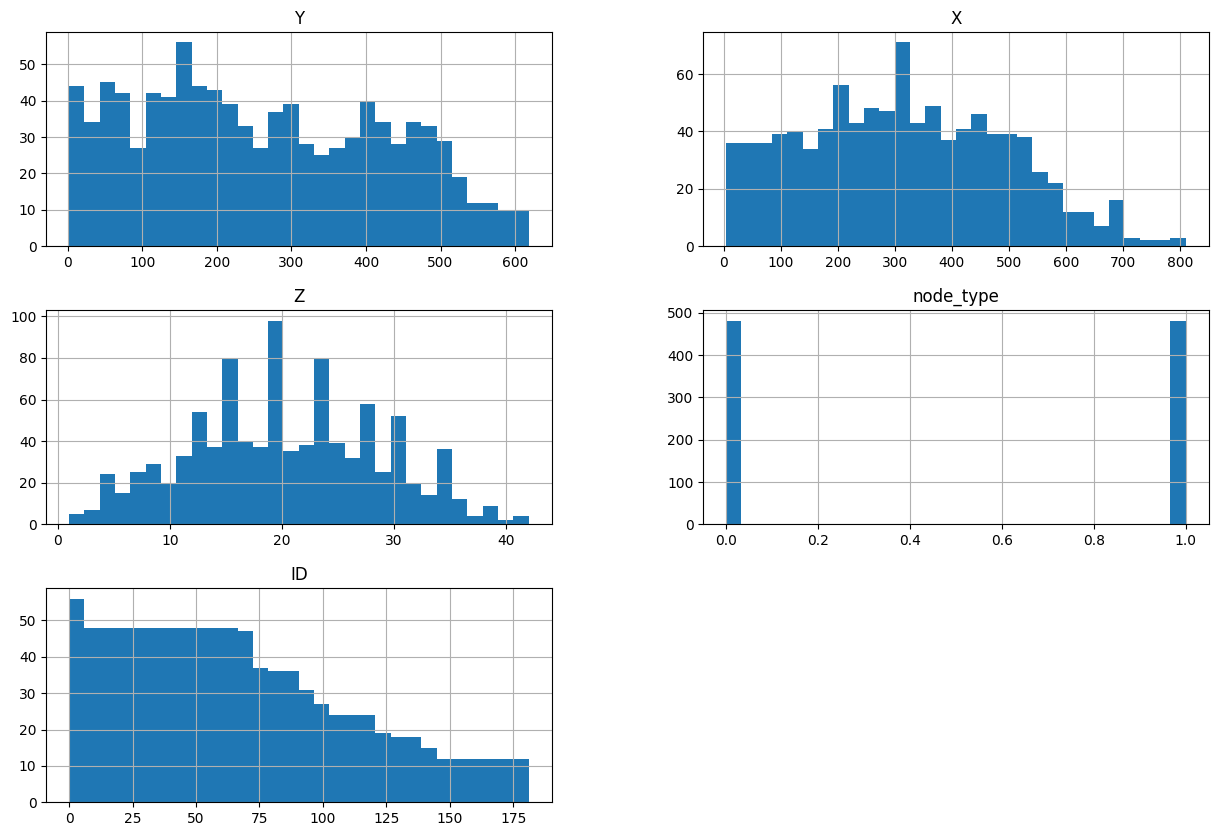

In [12]:
df.hist(bins=30, figsize=(15, 10))

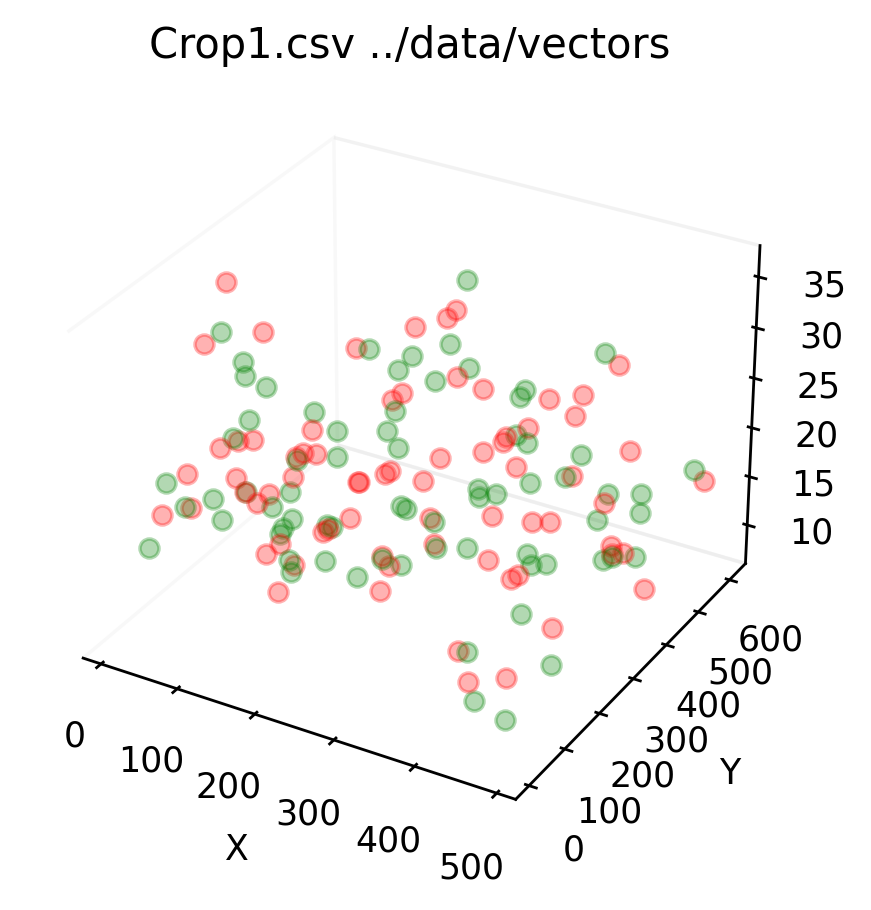

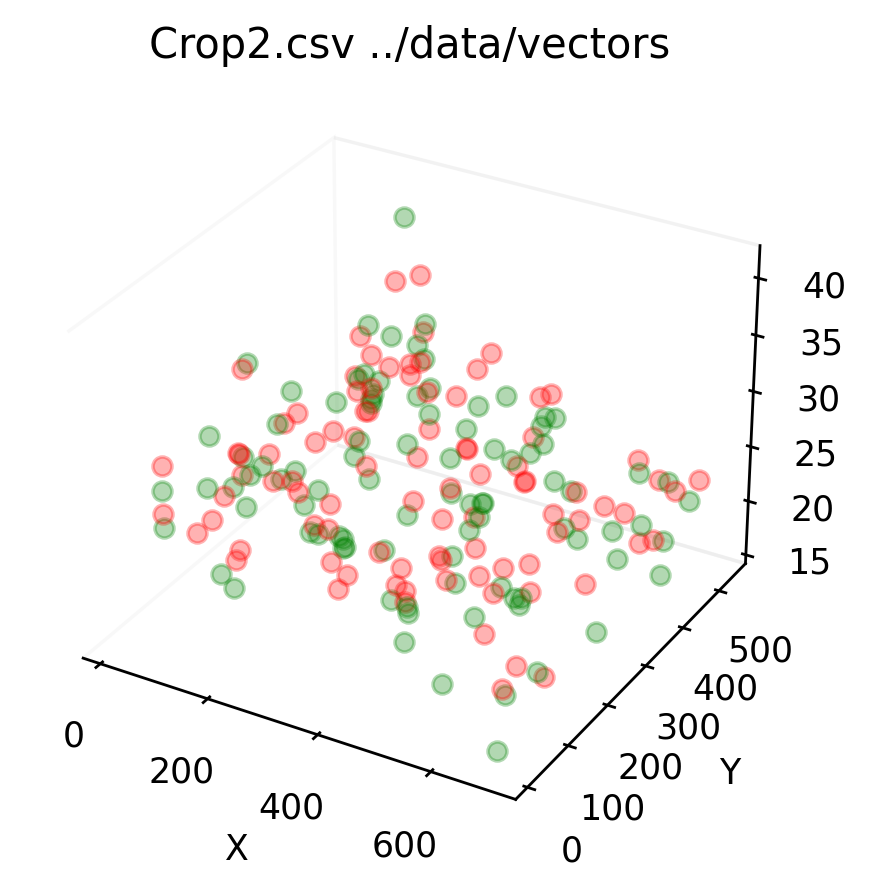

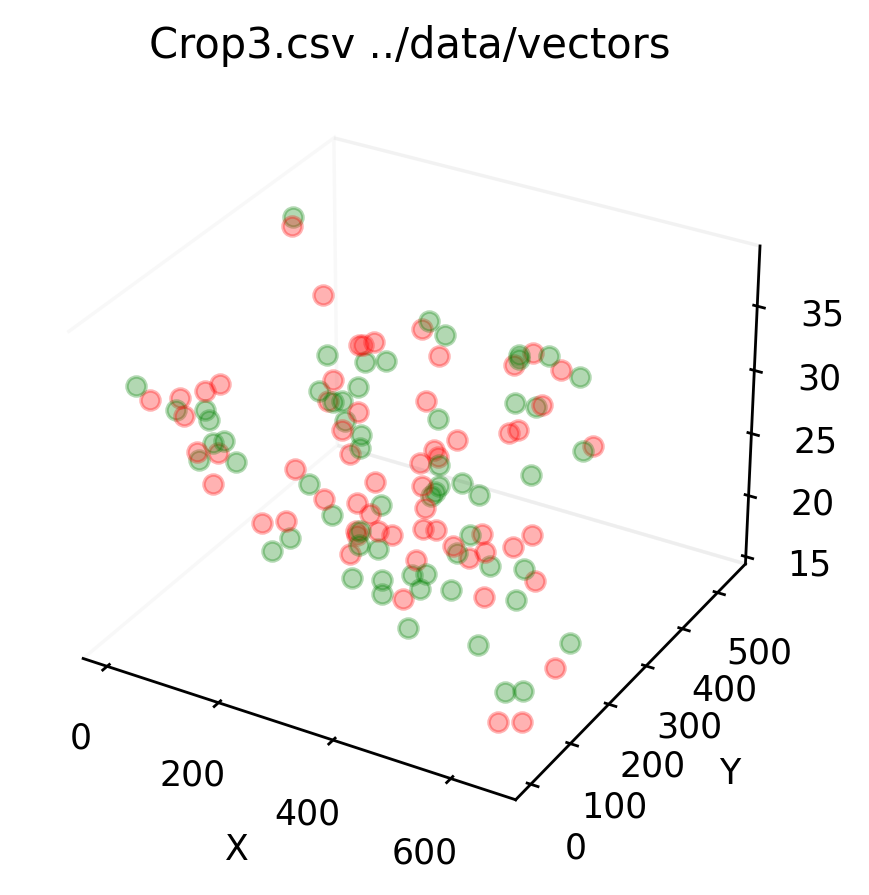

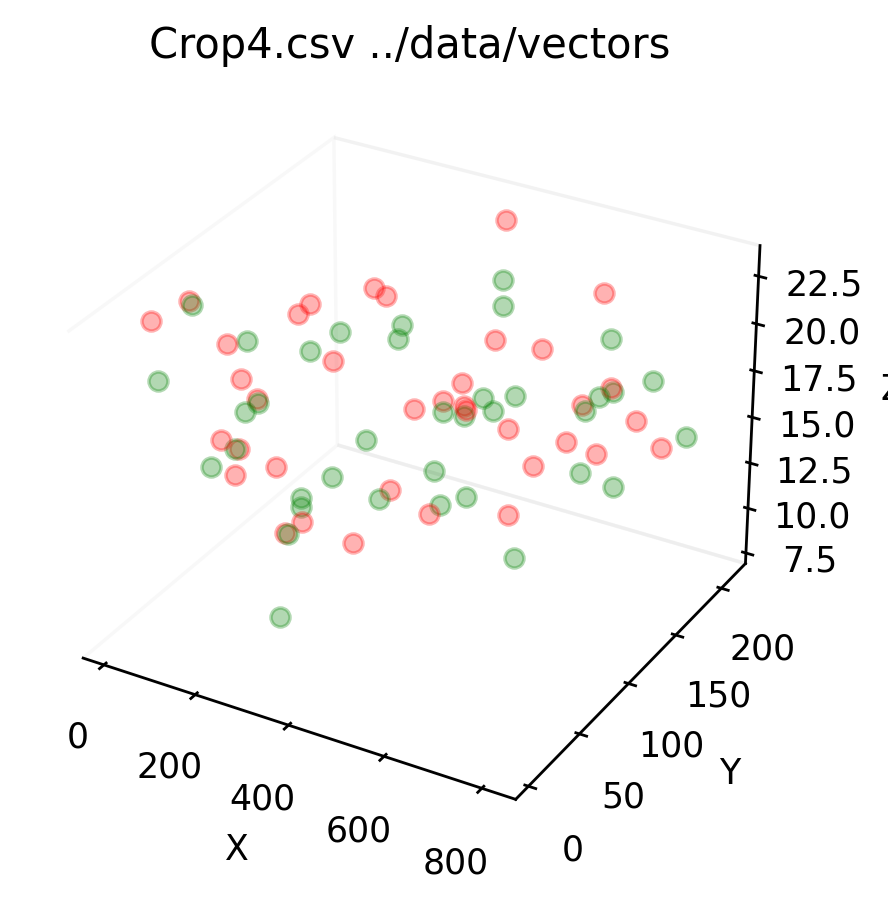

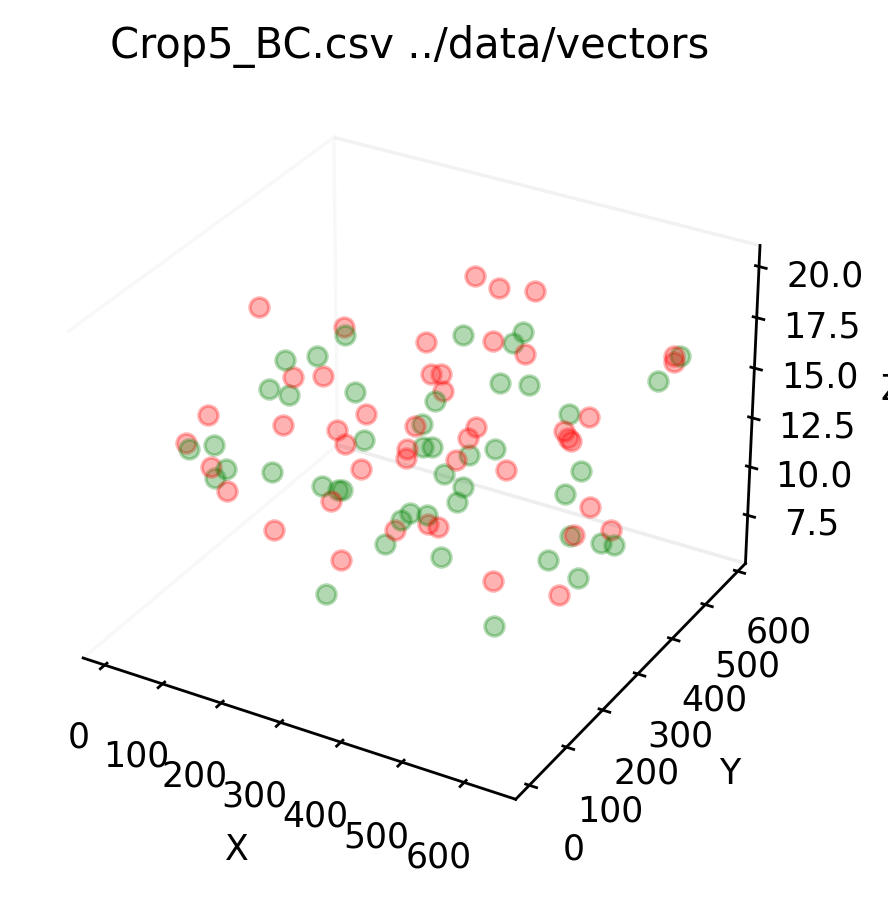

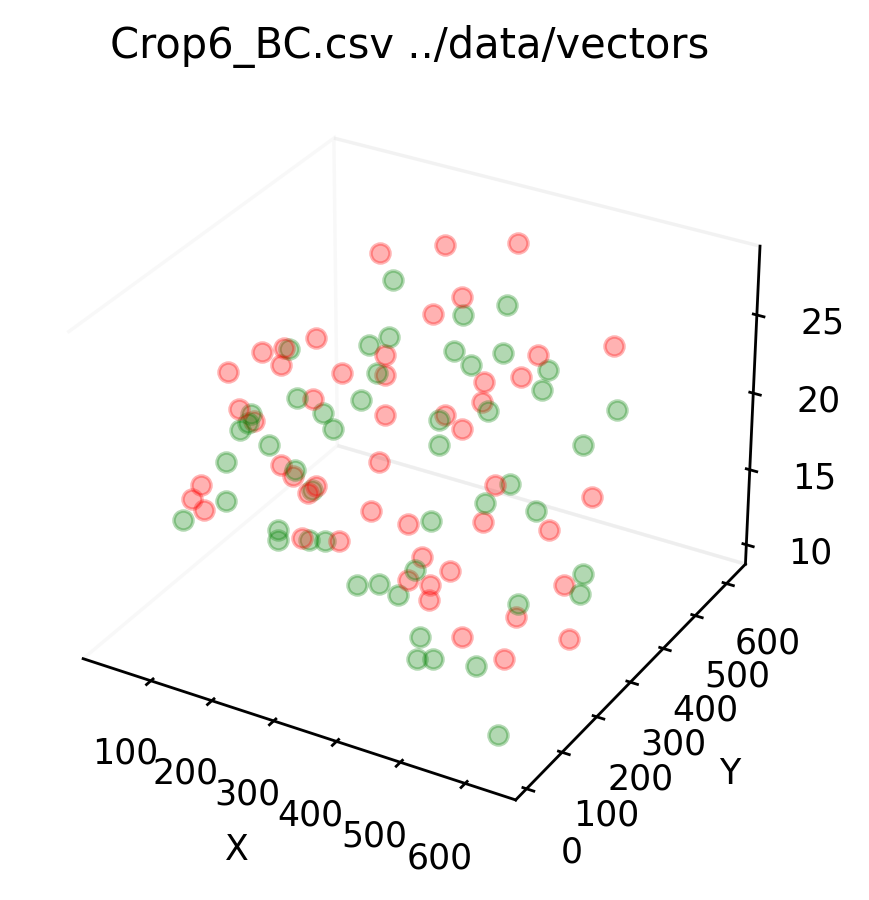

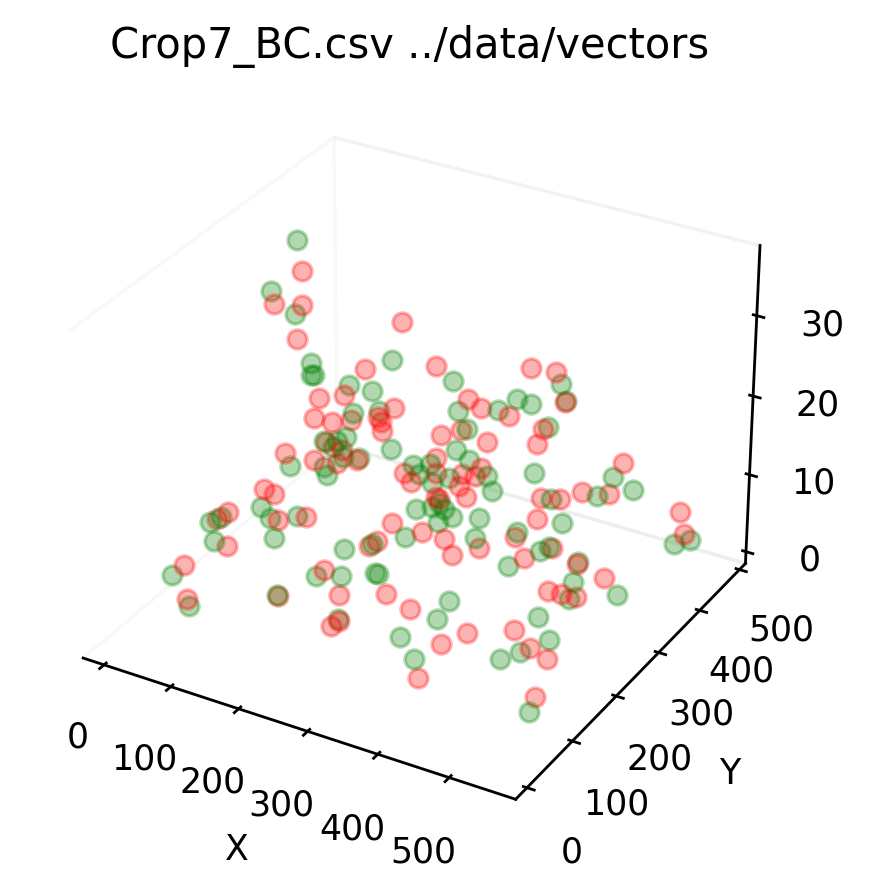

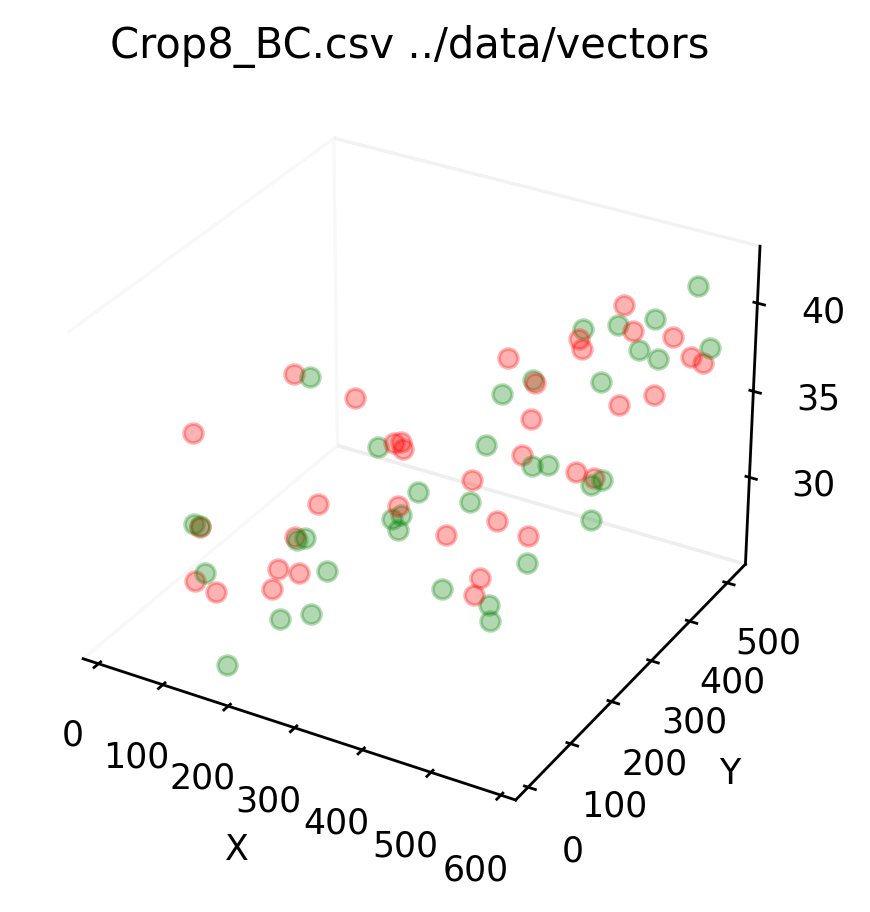

In [13]:
#create a graph to visualize nodes
for vector_sample in os.listdir(directory):
    vector_sample_path = os.path.join(directory, vector_sample)
    df, nodes_df, edges_df = load_df_from_csv(vector_sample_path)
    fig = GraphInfo.visualize_nodes_df(nodes_df)
    plt.title(vector_sample+" "+directory)
    plt.show()

In [14]:
def get_nested_dict(d, keys):
    nested_dict = None
    nested_dict = d.copy()
    for key in keys:
        nested_dict = nested_dict[key]
    return nested_dict

def plot_table(results_list, metrics_dict_entries = [["@best","metrics"],["@best","@constraints","metrics"]],
              make_print = False):
    
    df_entries = []
    
    # Print the formatted values in the desired order
    for result in results_list:
        
        metrics = result["aggregated_metrics"]
        
        dataset_params = result["job_parameters"]
        data_type_train = dataset_params["data_type_train"]
        data_type_test = dataset_params.get("data_type_test",data_type_train)
        angle_features = dataset_params["angle_features"]
        scale_features = dataset_params["scale_features"]
        normalize_features = dataset_params["normalize_features"]
        model_type = result["job_parameters"]["model_type"]
    
        k_intra = dataset_params["knn_intra_nodes"]
        k_inter = dataset_params["knn_inter_nodes"] 

        rouc_auc_score = metrics.get("rouc_auc_score","NA")
        
        count = 0
        for metrics_dict_entry in metrics_dict_entries:
            
            metrics_dict = None
            if metrics_dict_entry is None:
                metrics_dict = metrics
            else:
                metrics_dict = get_nested_dict(metrics, metrics_dict_entry)
                
            constraints = "NA" 
            if metrics_dict_entry is not None:
                constraints = False
                if "@constraints" in metrics_dict_entry:
                    constraints = True
            
            acc =  metrics_dict["acc"]
            precision = metrics_dict["precision"]
            recall = metrics_dict["recall"]
            f1_score = metrics_dict["f1_score"]
            fn = metrics_dict["fn"]
            tp = metrics_dict["tp"]
            fp = metrics_dict["fp"]
            tn = metrics_dict["tn"]
            tp_percent = metrics_dict["tp_percent"]
            tp_total_count = metrics_dict["tp_total_count"]

            # Check and format values
            formatted_k_intra = f"{k_intra:.3f}" if isinstance(k_intra, float) else k_intra
            formatted_k_inter = f"{k_inter:.3f}" if isinstance(k_inter, float) else k_inter
            formatted_rouc_auc_score = f"{rouc_auc_score:.3f}" if isinstance(rouc_auc_score, float) else rouc_auc_score
            formatted_acc= f"{acc:.3f}" if isinstance(acc, float) else acc
            formatted_precision = f"{precision:.3f}" if isinstance(precision, float) else precision
            formatted_recall = f"{recall:.3f}" if isinstance(recall, float) else recall
            formatted_f1_score = f"{f1_score:.3f}" if isinstance(f1_score, float) else f1_score
            formatted_tp = f"{tp:.3f}" if isinstance(tp, float) else tp
            formatted_fn = f"{fn:.3f}" if isinstance(fn, float) else fn
            formatted_tn = f"{tn:.3f}" if isinstance(tn, float) else tn
            formatted_fp = f"{fp:.3f}" if isinstance(fp, float) else fp
            formatted_tp_percent = f"{tp_percent:.3f}" if isinstance(tp_percent, float) else tp_percent
            formatted_tp_total_count = f"{tp_total_count:.3f}" if isinstance(tp_total_count, float) else tp_total_count

            formatted_values_dict = {
                "Algorithm": model_type, "Data Train": data_type_train, "Data Test":data_type_test, 
                "Constraints": constraints, "Normalize": normalize_features, 
                "Scale": scale_features, "Angles": angle_features,
                "K Intra": formatted_k_intra, "K Inter": formatted_k_inter, 
                "ROC AUC Score": formatted_rouc_auc_score, "Accuracy": formatted_acc, 
                "Precision": formatted_precision, "Recall": formatted_recall, "F1-Score": formatted_f1_score,
                "TP Percent": formatted_tp_percent, "TP Total Count": formatted_tp_total_count, 
                "TP":formatted_tp, "FP":formatted_fp, "TN":formatted_tn, "FN":formatted_fn
            }
            df_entries.append(formatted_values_dict)
           
            if(make_print):
                # Print the formatted values in the desired order
                if(count==0):
                    column_names = list(formatted_values_dict.keys())
                    # Print the column names
                    print("c|"*len(column_names))
                    column_string = ' & '.join(column_names) + ' \\\\'
                    print(column_string)
                    # Print the table separator (\hline)
                    print("\\hline")
                    count+=1

                formatted_values_list = [str(value) for value in list(formatted_values_dict.values())]
                formatted_string = ' & '.join(formatted_values_list) + ' \\\\'
                print(formatted_string)
            
    df = pd.DataFrame(df_entries).reset_index(drop=True)
    return df

def plot_df_to_latex(df, columns_to_drop = ['TP Total Count'], columns_min = ['FP', 'FN'], columns_max = ['ROC AUC Score', 
                            'TP Percent', 'F1-Score','Accuracy','Precision',
                             'Recall', "TP", "TN"]):
    #https://github.com/pandas-dev/pandas/issues/38328
    df = df.drop(columns=columns_to_drop)
    
    plot_str = df.style.highlight_min(subset= columns_min, props='textbf:--rwrap;')\
      .highlight_max(subset= columns_max, props='textbf:--rwrap').to_latex(hrules=True)
    
    return plot_str

In [15]:
output_dir = r'../data/synthetic_vectors'
n_samples = 8

#Tested distributions in this work
#generation_type = "random_walk_2D_z_normal_distribution"
#generation_type = "lin_1D_y_random_walk_z_fixed"
generation_type = "lin_1D_y_fixed_z_fixed"

#Other distributions
#generation_type = "random_walk_1D_y_fixed_z_normal_distribution"
#generation_type = "random_walk_1D_y_fixed_z_fixed"


output_dir_path = output_dir+"_"+generation_type

if not os.path.exists(output_dir_path):
    os.makedirs(output_dir_path)

In [16]:
#Uncomment to generate artificial data
"""
generate_artificial_dataset(output_dir_path, 
                                n_samples, 
                                number_points_dist = {"mu":2000,"sigma":50, "min":0}, 
                                proximity_factor_range =[0.15, 0.3], 
                                deviation_factor_range=[0, 0],
                                generation_type=generation_type)
"""

'\ngenerate_artificial_dataset(output_dir_path, \n                                n_samples, \n                                number_points_dist = {"mu":2000,"sigma":50, "min":0}, \n                                proximity_factor_range =[0.15, 0.3], \n                                deviation_factor_range=[0, 0],\n                                generation_type=generation_type)\n'

In [17]:
#Uncomment to generate artificial data
"""
number_of_points = 2000
nuclei_golgi_3D_path = generate_nuclei_golgi_3D(number_of_points, 
                                                proximity_factor_range=[0, 0.5], 
                                                deviation_factor_range=[0, 0], 
                                                generation_type=generation_type)

#fig = plot_3D_path(nuclei_golgi_3D_path)
fig = plot_3D_path_beautiful(nuclei_golgi_3D_path)
"""

'\nnumber_of_points = 2000\nnuclei_golgi_3D_path = generate_nuclei_golgi_3D(number_of_points, \n                                                proximity_factor_range=[0, 0.5], \n                                                deviation_factor_range=[0, 0], \n                                                generation_type=generation_type)\n\n#fig = plot_3D_path(nuclei_golgi_3D_path)\nfig = plot_3D_path_beautiful(nuclei_golgi_3D_path)\n'

# Results output dir

In [18]:
results_output_dir = "./results"
if not os.path.exists(results_output_dir):
    os.makedirs(results_output_dir)

In [19]:
def pred_df_to_csv(edges_df_bipartite, nodes_df):
    data_list = []
    
    pred_edges_df = edges_df_bipartite[edges_df_bipartite["edge_label"]==1].reset_index(drop=True)

    for idx, row in pred_edges_df.iterrows():
        nuclei_golgi_pair = {}

        source_id = row["source"]
        node = nodes_df[nodes_df["ID"]==source_id]
        node_type = reversed_nodes_type_int_encodings[node["node_type"].iloc[0]]
        nuclei_golgi_pair[node_type] = node

        target_id = row["target"]
        node = nodes_df[nodes_df["ID"]==target_id]
        node_type = reversed_nodes_type_int_encodings[node["node_type"].iloc[0]]
        nuclei_golgi_pair[node_type] = node

        nuclei = nuclei_golgi_pair["nuclei"]
        golgi = nuclei_golgi_pair["golgi"]

        xn, yn, zn = nuclei["X"].iloc[0], nuclei["Y"].iloc[0], nuclei["Z"].iloc[0]
        xg, yg, zg = golgi["X"].iloc[0], golgi["Y"].iloc[0], golgi["Z"].iloc[0]

        data_list.append([xn, yn, zn, xg, yg, zg])

    data_list = np.array(data_list)
    
    return data_list

# Bipartite Matching Algorithms

In [20]:
data_types = [
                #"Synthetic_random_walk_2D_z_normal_distribution",
                #"Synthetic_lin_1D_y_random_walk_z_fixed",
                #"Synthetic_lin_1D_y_fixed_z_fixed",
                #"Real_automatic",
                "Real"
]

combinations = {
    "data_type_train": data_types,
    "model_type":[
                    "Hopcroft_Karp",
                    "Minimum Weight"
    ],
    "knn_inter_nodes":[
                        #"min",
                        7
    ],
    "knn_inter_nodes_max": [7],
   "knn_intra_nodes":[0],
    "normalize_features":[False],#True, 
    "angle_features":[True]
}


job_parameters = []


# Generate all possible combinations of the dictionary values
for values in itertools.product(*combinations.values()):
    # Generate a dictionary for the combination of values
    job_dict = dict(zip(combinations.keys(), values))
    job_dict["scale_features"] = True if "Real" in job_dict["data_type_train"] else False
    job_parameters.append(job_dict)

print("Total Number of jobs is:",len(job_parameters))
print(json.dumps(job_parameters, indent = 1))

Total Number of jobs is: 2
[
 {
  "data_type_train": "Real",
  "model_type": "Hopcroft_Karp",
  "knn_inter_nodes": 7,
  "knn_inter_nodes_max": 7,
  "knn_intra_nodes": 0,
  "normalize_features": false,
  "angle_features": true,
  "scale_features": true
 },
 {
  "data_type_train": "Real",
  "model_type": "Minimum Weight",
  "knn_inter_nodes": 7,
  "knn_inter_nodes_max": 7,
  "knn_intra_nodes": 0,
  "normalize_features": false,
  "angle_features": true,
  "scale_features": true
 }
]


In [21]:
#build dataframes
graph_list_dict_bipartite = {}

for params in tqdm(job_parameters):
    
    params_list = [params["data_type_train"], params["knn_inter_nodes"], params["knn_intra_nodes"], 
                                    params["knn_inter_nodes_max"], params["normalize_features"], 
                                    params["scale_features"], params["angle_features"],
                                    False]
    params_list = [str(param_) for param_ in params_list]
    graph_key = "_".join(params_list)
    
    if graph_key not in graph_list_dict_bipartite:
        graph_list = get_graph_list(params["data_type_train"], params["knn_inter_nodes"], params["knn_intra_nodes"], 
                                        params["knn_inter_nodes_max"], 
                                        normalize_feats = params["normalize_features"], 
                                        scale_feats = params["scale_features"], angle_feats = params["angle_features"],
                                        shuffle = False)



        graph_list_dict_bipartite[graph_key] = graph_list

100%|██████████| 2/2 [00:08<00:00,  4.49s/it]





####################################
Graph_ID: Crop1.csv K_INTRA: 0 K_INTER: 7
{
 "tp": 53,
 "fp": 18,
 "tn": 408,
 "fn": 18,
 "acc": 0.928,
 "precision": 0.746,
 "recall": 0.746,
 "f1_score": 0.746,
 "tp_percent": 0.746,
 "tp_total_count": 71
}


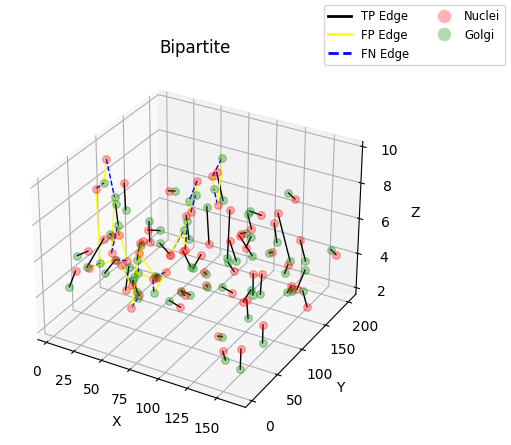

Graph_ID: Crop2.csv K_INTRA: 0 K_INTER: 7
{
 "tp": 59,
 "fp": 32,
 "tn": 514,
 "fn": 32,
 "acc": 0.9,
 "precision": 0.648,
 "recall": 0.648,
 "f1_score": 0.648,
 "tp_percent": 0.648,
 "tp_total_count": 91
}


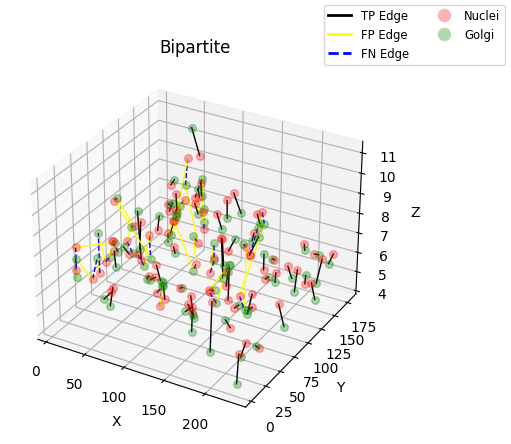

Graph_ID: Crop3.csv K_INTRA: 0 K_INTER: 7
{
 "tp": 45,
 "fp": 16,
 "tn": 350,
 "fn": 16,
 "acc": 0.925,
 "precision": 0.738,
 "recall": 0.738,
 "f1_score": 0.738,
 "tp_percent": 0.738,
 "tp_total_count": 61
}


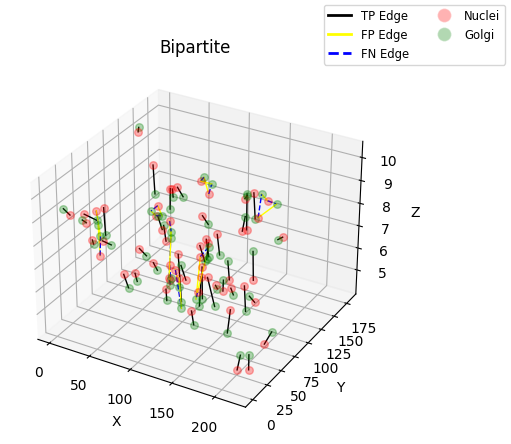

Graph_ID: Crop4.csv K_INTRA: 0 K_INTER: 7
{
 "tp": 26,
 "fp": 11,
 "tn": 211,
 "fn": 11,
 "acc": 0.915,
 "precision": 0.703,
 "recall": 0.703,
 "f1_score": 0.703,
 "tp_percent": 0.703,
 "tp_total_count": 37
}


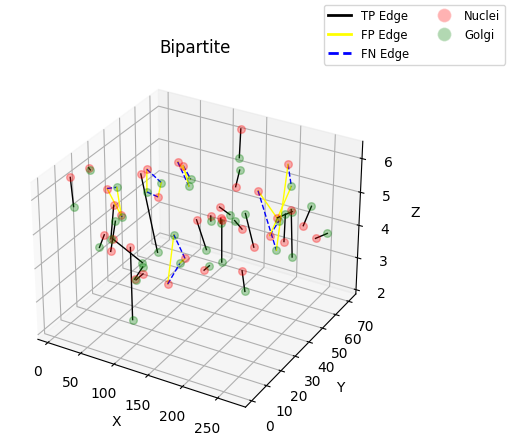

Graph_ID: Crop5_BC.csv K_INTRA: 0 K_INTER: 7
{
 "tp": 38,
 "fp": 8,
 "tn": 268,
 "fn": 8,
 "acc": 0.95,
 "precision": 0.826,
 "recall": 0.826,
 "f1_score": 0.826,
 "tp_percent": 0.826,
 "tp_total_count": 46
}


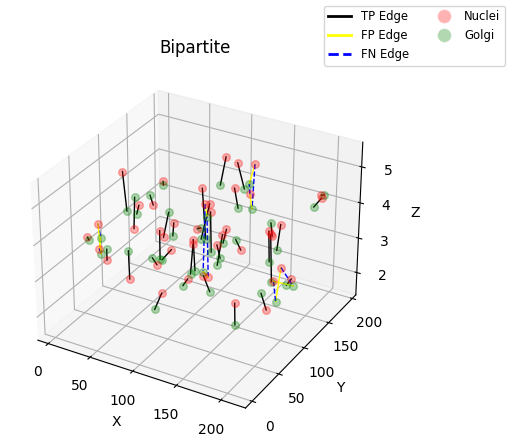

Graph_ID: Crop6_BC.csv K_INTRA: 0 K_INTER: 7
{
 "tp": 43,
 "fp": 7,
 "tn": 293,
 "fn": 7,
 "acc": 0.96,
 "precision": 0.86,
 "recall": 0.86,
 "f1_score": 0.86,
 "tp_percent": 0.86,
 "tp_total_count": 50
}


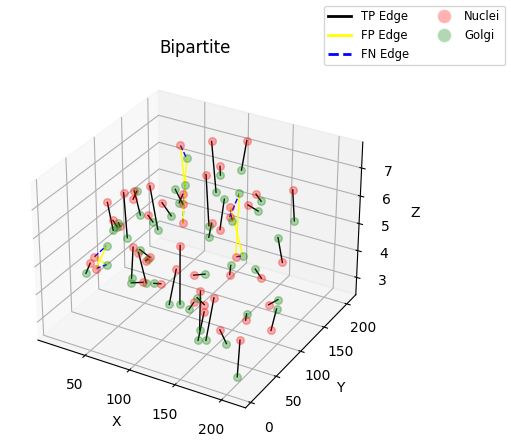

Graph_ID: Crop7_BC.csv K_INTRA: 0 K_INTER: 7
{
 "tp": 57,
 "fp": 33,
 "tn": 507,
 "fn": 33,
 "acc": 0.895,
 "precision": 0.633,
 "recall": 0.633,
 "f1_score": 0.633,
 "tp_percent": 0.633,
 "tp_total_count": 90
}


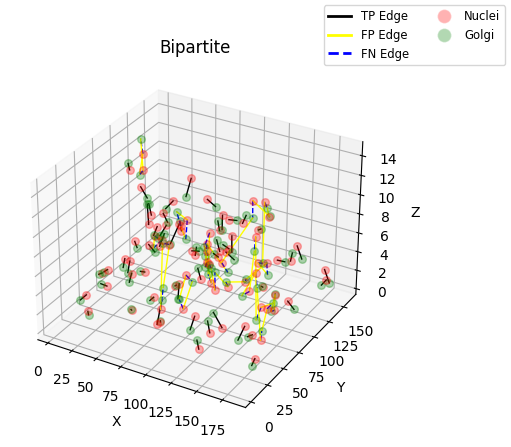

Graph_ID: Crop8_BC.csv K_INTRA: 0 K_INTER: 7
{
 "tp": 28,
 "fp": 8,
 "tn": 208,
 "fn": 8,
 "acc": 0.937,
 "precision": 0.778,
 "recall": 0.778,
 "f1_score": 0.778,
 "tp_percent": 0.778,
 "tp_total_count": 36
}


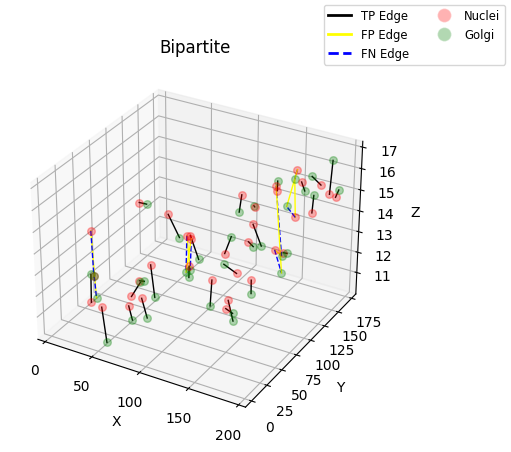

{
 "acc": 0.92625,
 "precision": 0.7415,
 "recall": 0.7415,
 "f1_score": 0.7415,
 "tp": 349,
 "fp": 133,
 "tn": 2759,
 "fn": 133,
 "tp_percent": 0.7415,
 "tp_total_count": 482
}



####################################
Graph_ID: Crop1.csv K_INTRA: 0 K_INTER: 7
{
 "tp": 67,
 "fp": 4,
 "tn": 422,
 "fn": 4,
 "acc": 0.984,
 "precision": 0.944,
 "recall": 0.944,
 "f1_score": 0.944,
 "tp_percent": 0.944,
 "tp_total_count": 71
}


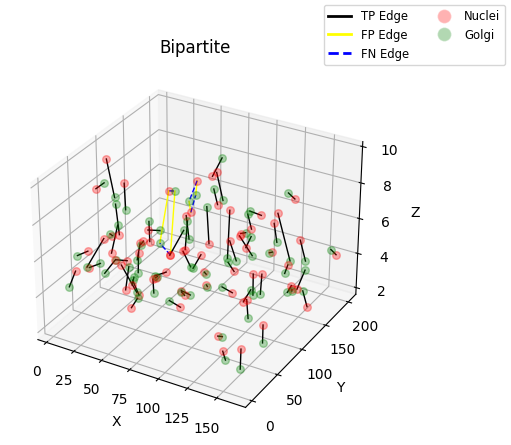

Graph_ID: Crop2.csv K_INTRA: 0 K_INTER: 7
{
 "tp": 84,
 "fp": 7,
 "tn": 539,
 "fn": 7,
 "acc": 0.978,
 "precision": 0.923,
 "recall": 0.923,
 "f1_score": 0.923,
 "tp_percent": 0.923,
 "tp_total_count": 91
}


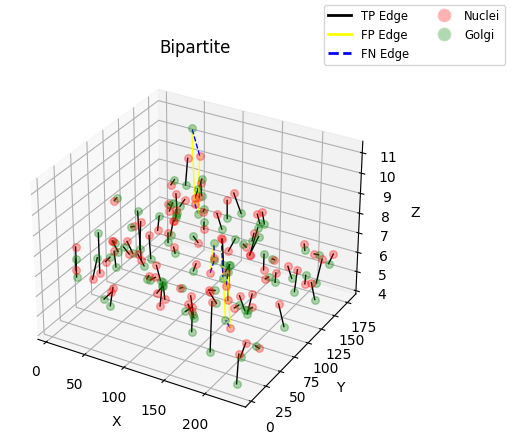

Graph_ID: Crop3.csv K_INTRA: 0 K_INTER: 7
{
 "tp": 57,
 "fp": 4,
 "tn": 362,
 "fn": 4,
 "acc": 0.981,
 "precision": 0.934,
 "recall": 0.934,
 "f1_score": 0.934,
 "tp_percent": 0.934,
 "tp_total_count": 61
}


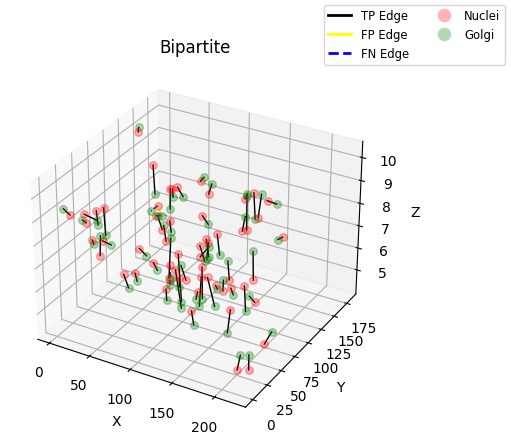

Graph_ID: Crop4.csv K_INTRA: 0 K_INTER: 7
{
 "tp": 33,
 "fp": 4,
 "tn": 218,
 "fn": 4,
 "acc": 0.969,
 "precision": 0.892,
 "recall": 0.892,
 "f1_score": 0.892,
 "tp_percent": 0.892,
 "tp_total_count": 37
}


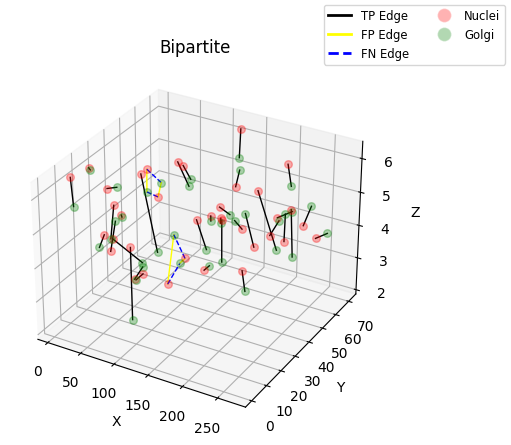

Graph_ID: Crop5_BC.csv K_INTRA: 0 K_INTER: 7
{
 "tp": 46,
 "fp": 0,
 "tn": 276,
 "fn": 0,
 "acc": 1.0,
 "precision": 1.0,
 "recall": 1.0,
 "f1_score": 1.0,
 "tp_percent": 1.0,
 "tp_total_count": 46
}


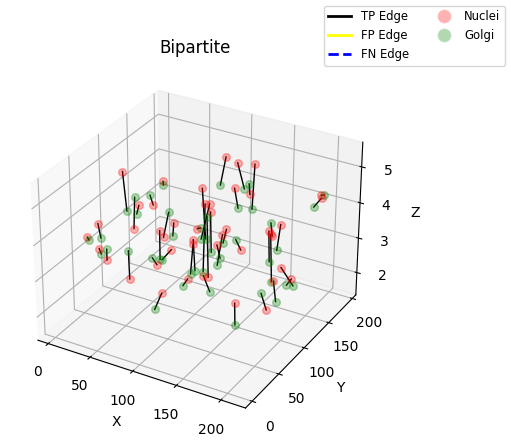

Graph_ID: Crop6_BC.csv K_INTRA: 0 K_INTER: 7
{
 "tp": 50,
 "fp": 0,
 "tn": 300,
 "fn": 0,
 "acc": 1.0,
 "precision": 1.0,
 "recall": 1.0,
 "f1_score": 1.0,
 "tp_percent": 1.0,
 "tp_total_count": 50
}


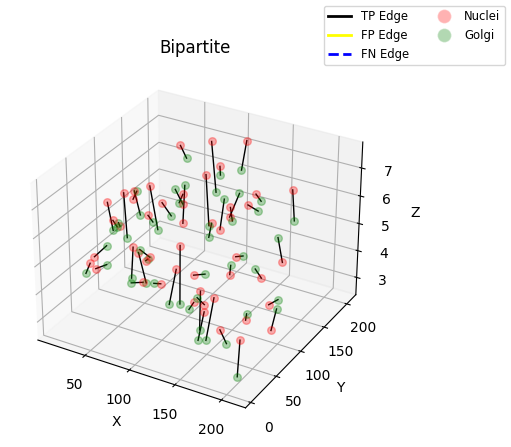

Graph_ID: Crop7_BC.csv K_INTRA: 0 K_INTER: 7
{
 "tp": 84,
 "fp": 6,
 "tn": 534,
 "fn": 6,
 "acc": 0.981,
 "precision": 0.933,
 "recall": 0.933,
 "f1_score": 0.933,
 "tp_percent": 0.933,
 "tp_total_count": 90
}


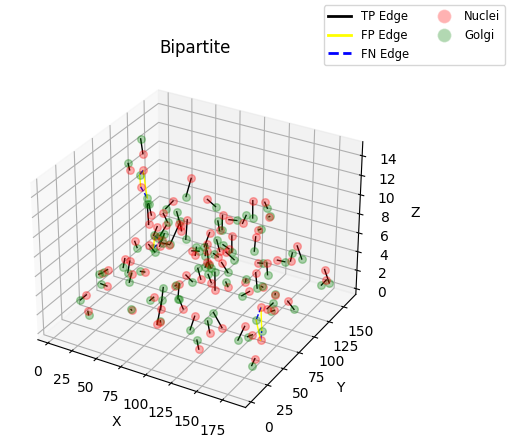

Graph_ID: Crop8_BC.csv K_INTRA: 0 K_INTER: 7
{
 "tp": 34,
 "fp": 2,
 "tn": 214,
 "fn": 2,
 "acc": 0.984,
 "precision": 0.944,
 "recall": 0.944,
 "f1_score": 0.944,
 "tp_percent": 0.944,
 "tp_total_count": 36
}


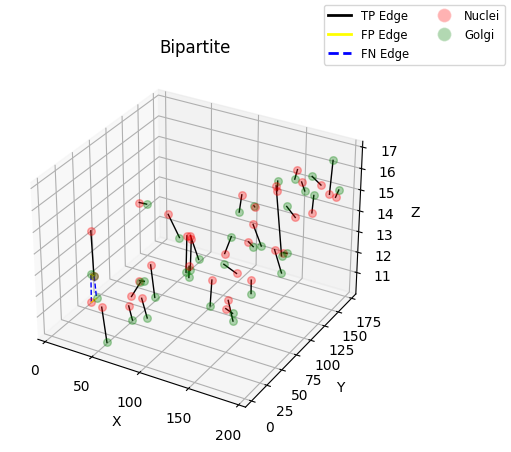

{
 "acc": 0.984625,
 "precision": 0.94625,
 "recall": 0.94625,
 "f1_score": 0.94625,
 "tp": 455,
 "fp": 27,
 "tn": 2865,
 "fn": 27,
 "tp_percent": 0.94625,
 "tp_total_count": 482
}


In [22]:
results_list_mf = []
make_plots = True

for params in job_parameters:
    print("\n\n\n####################################")
    metrics_list_bipartite = []
    
    params_list = [params["data_type_train"], params["knn_inter_nodes"], params["knn_intra_nodes"], 
                                    params["knn_inter_nodes_max"], params["normalize_features"], 
                                    params["scale_features"], params["angle_features"],
                                    False]
    params_list = [str(param_) for param_ in params_list]
    graph_key = "_".join(params_list)
    graph_list = graph_list_dict_bipartite[graph_key]
    
    for graph in graph_list:
        graph_id, nodes_df, edges_df, edges_df_knn, k_intra, k_inter = graph.graph_id, graph.nodes_df, graph.edges_df, graph.edges_df_knn, graph.k_intra, graph.k_inter
        print("Graph_ID:",graph_id,"K_INTRA:",k_intra, "K_INTER:",k_inter)
        
        edges_df_bipartite_graph = edges_df_knn.copy()
        #edges_df_bipartite_graph = edges_df_bipartite_graph.drop(columns=['edge_label'])
        #edges_df_bipartite_graph = edges_df_bipartite_graph.sort_values(by=edges_df_bipartite_graph.columns.tolist()).reset_index(drop=True)
        nx_G_knn = nx_build_graph(nodes_df, edges_df_bipartite_graph)
        
        model_type = params["model_type"]
        
        #get the bipartite edges_list
        if(model_type=="Hopcroft_Karp"):
            nx_bipartite_edges_list = nx.bipartite.maximum_matching(nx_G_knn)
            #Other alternative
            #graph_for_algo = create_edge_dict(edges_df_bipartite_graph)
            #nx_bipartite_edges_list = HopcroftKarp(graph_for_algo).maximum_matching()
        elif(model_type=="Eppstein"):
            nx_bipartite_edges_list = nx.bipartite.eppstein_matching(nx_G_knn)
        elif(model_type=="Minimum Weight"):
            nx_bipartite_edges_list = nx.bipartite.minimum_weight_full_matching(nx_G_knn)
        else:
            raise ValueError("Model not implemented!")
        
        #convert to Dataframe
        edges_df_bipartite = nx_convert_dict_to_edges_df(nx_bipartite_edges_list)
        #apply the pred labels to edges_df_bipartite, taking as input the edges_df_knn
        edges_df_bipartite["edge_label"] = 1
        edges_df_bipartite = apply_edges_df_label(edges_df_bipartite, edges_df_knn)
    
        metrics_bipartite, edge_labels_string_bipartite = eval_edges_df(edges_df, edges_df_bipartite)
        metrics_list_bipartite.append(metrics_bipartite)
        
        print(json.dumps(metrics_bipartite, indent = 1))
        
        #Save results to file
        bipartite_results_array = pred_df_to_csv(edges_df_bipartite, graph.nodes_df_original)
        output_file_dir =  results_output_dir+"/"+params["data_type_train"]+"_"+params["model_type"]+"_" +\
                                str(params["knn_inter_nodes"])+"_"+str(params["knn_intra_nodes"])+"/"
        if not os.path.exists(output_file_dir):
            os.makedirs(output_file_dir)
        output_file_path = os.path.join(output_file_dir, graph.graph_id)
        array_to_csv(bipartite_results_array, output_file_path)
        
        if(make_plots):
            #fig_true = df_make_plot(nodes_df, edges_df, ["tp"]*len(edges_df), "True")
            #fig_knn = df_make_plot(nodes_df, edges_df_knn, ["tp"]*len(edges_df_knn), "KNN")
            fig_bipartite = df_make_plot(nodes_df, edges_df_bipartite, edge_labels_string_bipartite, "Bipartite")
            plt.show()
    
    ####################################
    ### Aggregate Metrics at the end  ##
    ####################################
    
    metrics_bipartite_aggregated = aggregate_metrics(metrics_list_bipartite)
    print(json.dumps(metrics_bipartite_aggregated,indent = 1))

    result_bipartite = {}
    result_bipartite["aggregated_metrics"] = metrics_bipartite_aggregated
    params["angle_features"] = "NA"
    params["constraints"] = "NA"
    result_bipartite["job_parameters"] = params
    results_list_mf.append(result_bipartite)

In [23]:
plot_df_mf = plot_table(results_list_mf, metrics_dict_entries = [None])

In [24]:
plot_df_mf = plot_df_mf.sort_values(by=["K Inter", 'Algorithm', 'Data Train', 'Data Test'])
plot_df_mf

,Algorithm,Data Train,Data Test,Constraints,Normalize,Scale,Angles,K Intra,K Inter,ROC AUC Score,Accuracy,Precision,Recall,F1-Score,TP Percent,TP Total Count,TP,FP,TN,FN
0,Hopcroft_Karp,Real,Real,NA,False,True,NA,0,7,NA,0.926,0.742,0.742,0.742,0.742,482,349,133,2759,133
1,Minimum Weight,Real,Real,NA,False,True,NA,0,7,NA,0.985,0.946,0.946,0.946,0.946,482,455,27,2865,27


In [25]:
plot_df_mf = plot_df_mf.drop(["Data Train", "Data Test", "Normalize", "Scale"], axis=1)
plot_df_mf

,Algorithm,Constraints,Angles,K Intra,K Inter,ROC AUC Score,Accuracy,Precision,Recall,F1-Score,TP Percent,TP Total Count,TP,FP,TN,FN
0,Hopcroft_Karp,NA,NA,0,7,NA,0.926,0.742,0.742,0.742,0.742,482,349,133,2759,133
1,Minimum Weight,NA,NA,0,7,NA,0.985,0.946,0.946,0.946,0.946,482,455,27,2865,27


In [26]:
print(plot_df_to_latex(plot_df_mf))

\begin{tabular}{llllrrllllllrrrr}
\toprule
 & Algorithm & Constraints & Angles & K Intra & K Inter & ROC AUC Score & Accuracy & Precision & Recall & F1-Score & TP Percent & TP & FP & TN & FN \\
\midrule
0 & Hopcroft_Karp & NA & NA & 0 & 7 & \textbf{NA} & 0.926 & 0.742 & 0.742 & 0.742 & 0.742 & 349 & 133 & 2759 & 133 \\
1 & Minimum Weight & NA & NA & 0 & 7 & \textbf{NA} & \textbf{0.985} & \textbf{0.946} & \textbf{0.946} & \textbf{0.946} & \textbf{0.946} & \textbf{455} & \textbf{27} & \textbf{2865} & \textbf{27} \\
\bottomrule
\end{tabular}



# Sklearn

In [ ]:
import sklearn.ensemble

In [ ]:
k_intra = 0
k_inter = 5#"min"
k_inter_max = 5

graph_list = get_graph_list("Real", k_inter, k_intra, k_inter_max, normalize_feats = False, shuffle = True)

In [ ]:
clf = sklearn.ensemble.RandomForestClassifier(max_depth=20, random_state=0)

In [ ]:
train_index = 4
test_index = 1

graph_train = graph_list[train_index]
X_train_true, Y_train_true, X_train_knn, Y_train_knn = sklearn_get_dataset(graph_train, shuffle = True)

graph_test = graph_list[test_index]
X_test_true, Y_test_true, X_test_knn, Y_test_knn = sklearn_get_dataset(graph_test, shuffle = True)

In [ ]:
clf = clf.fit(X_train_knn, Y_train_knn)

In [ ]:
Y_test_pred = clf.predict(X_test_knn)

In [ ]:
eval_metrics(Y_test_knn, Y_test_pred, len(Y_test_true))

# Deep Learning Pytorch
Packages versions:
- torchmetrics==0.5.0
- pytorch-lightning==1.5.10

In [27]:
from polarmot_utils import *

In [28]:
def _build_params_dict_polarmot(initial_edge_model_input_dim, edge_dim, fc_dims_initial_edge_model_multipliers, nonlinearity_initial_edge,
                       fc_dims_initial_node_model_multipliers, nonlinearity_initial_node, 
                       directed_flow_agg, fc_dims_directed_flow_attention_model_multipliers,
                       fc_dims_edge_model_multipliers, nonlinearity_edge,
                       fc_dims_directed_flow_model_multipliers, nonlinearity_directed_flow, 
                       fc_dims_total_flow_model_multipliers, nonlinearity_total_flow,
                       fc_dims_edge_classification_model_multipliers, nonlinearity_edge_classification,
                       use_batchnorm: bool,
                       mpn_steps: int, is_recurrent: bool, node_dim_multiplier: int, pos_weight_multiplier: int,
                       use_timeaware: bool, use_same_frame: bool, use_separate_edge_model: bool, use_initial_node_model: bool,
                       edge_mlps_count: int,
                       node_aggr_sections: int,
                       lr, wd, loss_type: str,
                       seed,
                       optimizer_type,
                       scheduler_params: Mapping,
                       trainer_params: Mapping,
                       **kwargs,
                       ):
    # workaround before adding sacred
    params = {
        "seed": seed,

        "initial_edge_model_input_dim": initial_edge_model_input_dim,
        "edge_dim": edge_dim,

        "fc_dims_initial_edge_model_multipliers": fc_dims_initial_edge_model_multipliers,
        "nonlinearity_initial_edge": nonlinearity_initial_edge,

        "fc_dims_initial_node_model_multipliers": fc_dims_initial_node_model_multipliers,
        "nonlinearity_initial_node": nonlinearity_initial_node,
        "directed_flow_agg": directed_flow_agg,
        "fc_dims_directed_flow_attention_model_multipliers": fc_dims_directed_flow_attention_model_multipliers,

        "fc_dims_edge_model_multipliers": fc_dims_edge_model_multipliers,
        "nonlinearity_edge": nonlinearity_edge,

        "fc_dims_directed_flow_model_multipliers": fc_dims_directed_flow_model_multipliers,
        "nonlinearity_directed_flow": nonlinearity_directed_flow,

        "fc_dims_total_flow_model_multipliers": fc_dims_total_flow_model_multipliers,
        "nonlinearity_total_flow": nonlinearity_total_flow,

        "fc_dims_edge_classification_model_multipliers": fc_dims_edge_classification_model_multipliers,
        "nonlinearity_edge_classification": nonlinearity_edge_classification,

        "use_batchnorm": use_batchnorm,

        "mpn_steps": mpn_steps,
        "is_recurrent": is_recurrent,
        "node_dim_multiplier": node_dim_multiplier,
        "pos_weight_multiplier": pos_weight_multiplier,

        "use_timeaware": use_timeaware,
        "use_same_frame": use_same_frame,
        "use_separate_edge_model": use_separate_edge_model,
        "use_initial_node_model": use_initial_node_model,
        "edge_mlps_count": edge_mlps_count,
        "node_aggr_sections": node_aggr_sections,

        "lr": lr,
        "wd": wd,
        "loss_type": loss_type,
        "optimizer_type": optimizer_type,
        "scheduler_params": scheduler_params,

        "trainer_params": trainer_params,
    }
    params.update(kwargs)
    return params

def _build_models_polarmot(params: Mapping[str, Any]):
    use_batchnorm = params["use_batchnorm"]

    edge_dim = params["edge_dim"]
    node_dim_multiplier = params.get("node_dim_multiplier", 2)
    node_dim = edge_dim * node_dim_multiplier  # Have nodes hold 2x info of edges
    use_timeaware = params.get("use_timeaware", True)
    use_same_frame = params.get("use_same_frame", False)
    # separate backward/forward/sameframe MLPs or inter/intraframe or single MLP for all
    edge_mlps_count = params.get("edge_mlps_count", 3)
    assert edge_mlps_count > 0 and edge_mlps_count <= 3, f"edge_mlps_count must be 1/2/3, not {edge_mlps_count}"
    node_aggr_sections = params.get("node_aggr_sections", 3)
    assert node_aggr_sections > 0 and node_aggr_sections <= 3, f"node_aggr_sections must be 1/2/3, not {node_aggr_sections}"
    # only makes sense when using intraframe
    use_separate_edge_model = use_same_frame and params.get("use_separate_edge_model", False) 
    use_initial_node_model = params.get("use_initial_node_model", True)

    # Edge classification model
    fc_dims_edge_classification_model_multipliers = params["fc_dims_edge_classification_model_multipliers"]
    if fc_dims_edge_classification_model_multipliers is not None:
        fc_dims_edge_classification_model = dims_from_multipliers(
            edge_dim, fc_dims_edge_classification_model_multipliers) + (1,)
    else:
        fc_dims_edge_classification_model = (1,)
    edge_classifier = MLP(edge_dim, fc_dims_edge_classification_model,
                          params["nonlinearity_edge_classification"], last_output_free=True)

    # Initial edge model:
    fc_dims_initial_edge = dims_from_multipliers(
        edge_dim, params["fc_dims_initial_edge_model_multipliers"])
    initial_edge_model = MLP(params["initial_edge_model_input_dim"], fc_dims_initial_edge,
                            params["nonlinearity_initial_edge"], use_batchnorm=use_batchnorm)
    if use_separate_edge_model:
        initial_same_frame_edge_model = MLP(params["initial_edge_model_input_dim"], fc_dims_initial_edge,
                                            params["nonlinearity_initial_edge"], use_batchnorm=use_batchnorm)
    else:
        initial_same_frame_edge_model = None

    # Initial node model
    if use_initial_node_model:
        initial_node_agg_mode = params["directed_flow_agg"]
        if "attention" in initial_node_agg_mode:
            if "classifier" in initial_node_agg_mode:
                initial_node_attention_model = edge_classifier
            else:
                fc_dims_directed_flow_attention_model_multipliers = params["fc_dims_directed_flow_attention_model_multipliers"]
                if fc_dims_directed_flow_attention_model_multipliers is not None:
                    fc_dims_initial_node_attention = dims_from_multipliers(
                        edge_dim, fc_dims_directed_flow_attention_model_multipliers) + (1,)
                else:
                    fc_dims_initial_node_attention = (1,)
                initial_node_attention_model = MLP(edge_dim, fc_dims_initial_node_attention,
                                                params["nonlinearity_initial_node"], last_output_free=True)
        else:
            initial_node_attention_model = None

        fc_dims_initial_node = dims_from_multipliers(
            node_dim, params["fc_dims_initial_node_model_multipliers"])
        if use_timeaware:
            if use_same_frame:
                initial_node_model = InitialContextualNodeModel(MLP(edge_dim * 3, fc_dims_initial_node,
                                                                params["nonlinearity_initial_node"], use_batchnorm=use_batchnorm),
                                                                initial_node_agg_mode, initial_node_attention_model)
            else:
                initial_node_model = InitialTimeAwareNodeModel(MLP(edge_dim * 2, fc_dims_initial_node,  # x2 for [forward|backward] edge features
                                                                   params["nonlinearity_initial_node"], use_batchnorm=use_batchnorm),
                                                               initial_node_agg_mode)
        else:
            assert not use_same_frame
            initial_node_model = InitialUniformAggNodeModel(MLP(edge_dim, fc_dims_initial_node,
                                                                params["nonlinearity_initial_node"], use_batchnorm=use_batchnorm),
                                                            initial_node_agg_mode)
    else:  # initial nodes are zero vectors
        initial_node_model = InitialZeroNodeModel(node_dim)

    # Define models in MPN
    edge_models, node_models = [], []
    steps = params["mpn_steps"]
    assert steps > 1, "Fewer than 2 MPN steps does not make sense as in that case nodes do not get a chance to update"
    is_recurrent = params["is_recurrent"]
    for step in range(steps):
        # Edge model
        edge_model_input = node_dim * 2 + edge_dim  # edge_dim * 5
        fc_dims_edge = dims_from_multipliers(
            edge_dim, params["fc_dims_edge_model_multipliers"])
        edge_models.append(BasicEdgeModel(MLP(edge_model_input, fc_dims_edge,
                                              params["nonlinearity_edge"], use_batchnorm=use_batchnorm)))

        if step == steps - 1: # don't need a node update at the last step
            continue

        # Node model
        flow_model_input = node_dim * 2 + edge_dim  # two nodes and their edge
        fc_dims_directed_flow = dims_from_multipliers(
            node_dim, params["fc_dims_directed_flow_model_multipliers"])
        fc_dims_aggregated_flow = dims_from_multipliers(
            node_dim, params["fc_dims_total_flow_model_multipliers"])
        
        node_agg_mode = params["directed_flow_agg"]
        if "attention" in node_agg_mode:
            if "classifier" in node_agg_mode:
                attention_model = edge_classifier
            else:
                fc_dims_directed_flow_attention_model_multipliers = params["fc_dims_directed_flow_attention_model_multipliers"]
                if fc_dims_directed_flow_attention_model_multipliers is not None:
                    fc_dims_directed_flow_attention = dims_from_multipliers(
                        node_dim, fc_dims_directed_flow_attention_model_multipliers) + (1,)
                else:
                    fc_dims_directed_flow_attention = (1,)
                attention_model = MLP(node_dim, fc_dims_directed_flow_attention,
                                    params["nonlinearity_directed_flow"], last_output_free=True)
        else:
            attention_model = None

        if use_timeaware:
            forward_flow_model = MLP(flow_model_input, fc_dims_directed_flow,
                                     params["nonlinearity_directed_flow"], use_batchnorm=use_batchnorm)
            if edge_mlps_count < 3:
                backward_flow_model = forward_flow_model
            else:
                backward_flow_model = MLP(flow_model_input, fc_dims_directed_flow,
                                        params["nonlinearity_directed_flow"], use_batchnorm=use_batchnorm)
            if use_same_frame:
                if edge_mlps_count == 1:
                    frame_flow_model = forward_flow_model
                else:
                    frame_flow_model = MLP(flow_model_input, fc_dims_directed_flow,
                                        params["nonlinearity_directed_flow"], use_batchnorm=use_batchnorm)
                aggregated_flow_model = MLP(node_dim * 3, fc_dims_aggregated_flow,
                                            params["nonlinearity_total_flow"], use_batchnorm=use_batchnorm)
                node_models.append(ContextualNodeModel(
                    forward_flow_model, frame_flow_model, backward_flow_model, aggregated_flow_model, node_agg_mode, attention_model, node_aggr_sections=node_aggr_sections))

            else:
                aggregated_flow_model = MLP(node_dim * 2, fc_dims_aggregated_flow,
                                            params["nonlinearity_total_flow"], use_batchnorm=use_batchnorm)
                node_models.append(TimeAwareNodeModel(
                    forward_flow_model, backward_flow_model, aggregated_flow_model, node_agg_mode))
        else:
            individual_flow_model = MLP(flow_model_input, fc_dims_directed_flow,
                                        params["nonlinearity_directed_flow"], use_batchnorm=use_batchnorm)
            aggregated_flow_model = MLP(node_dim, fc_dims_aggregated_flow,
                                        params["nonlinearity_total_flow"], use_batchnorm=use_batchnorm)
            node_models.append(UniformAggNodeModel(individual_flow_model,
                               aggregated_flow_model, node_agg_mode))

        if is_recurrent:  # only one model to use at each step
            break

    if is_recurrent:
        assert len(edge_models) == len(node_models) == 1
        if use_separate_edge_model:
            same_frame_edge_model = BasicEdgeModel(MLP(edge_model_input, fc_dims_edge, params["nonlinearity_edge"],
                                                    use_batchnorm=use_batchnorm))
        else:
            same_frame_edge_model = None

        if use_initial_node_model:
            mpn_model = MessagePassingNetworkRecurrent(edge_models[0], node_models[0], steps,
                                                    use_same_frame, same_frame_edge_model)
        else:  # use a node-to-edge MPN
            mpn_model = MessagePassingNetworkRecurrentNodeEdge(edge_models[0], node_models[0], steps,
                                                               use_same_frame, same_frame_edge_model)
    else:
        mpn_model = MessagePassingNetworkNonRecurrent(edge_models, node_models, steps, use_same_frame)

    return initial_edge_model, initial_same_frame_edge_model, initial_node_model, mpn_model, edge_classifier

In [29]:
class GraphClassifierPolarMOT(pl.LightningModule):
    def __init__(self, params: Mapping):
        """ Top level model class holding all components necessary to perform tracking on a graph
        :param initial_same_frame_edge_model: a torch model processing initial edge attributes for same frame edges
        :param initial_node_model: a torch model processing edge attributes to get initial node features
        :param mpn_model: a message passing model
        :param edge_classifier: a final classification model operating on final edge features
        :param params: params
        """
        super().__init__()
        self.params = params
        
        #change this because we only one edge model
        (self.initial_edge_model, self.initial_same_frame_edge_model, self.initial_node_model,
             self.mpn_model, self.edge_classifier) = _build_models_polarmot(params)
        

        self.loss_type = self.params["loss_type"]
        self.use_same_frame = self.params["use_same_frame"]
        self.pos_weight_multiplier = self.params["pos_weight_multiplier"]
        
        self.save_hyperparameters()
    
    def forward(self, data):
        edge_index, edge_attr, num_nodes = data.edge_index.long(), data.edge_attr, data.num_nodes
        same_frame_edge_index = data.same_frame_edge_index.long() if self.use_same_frame else None
        same_frame_edge_attr = data.same_frame_edge_attr if self.use_same_frame else None

        # Initial Edge embeddings with Null node embeddings
        edge_attr = self.initial_edge_model(edge_attr)
        if self.use_same_frame:
            if self.initial_same_frame_edge_model is not None:
                same_frame_edge_attr = self.initial_same_frame_edge_model(same_frame_edge_attr)
            else:
                same_frame_edge_attr = self.initial_edge_model(same_frame_edge_attr)
        
        # Initial Node embeddings with Null original embeddings
        x = self.initial_node_model(edge_index, edge_attr, num_nodes,
                                    same_frame_edge_index=same_frame_edge_index, 
                                    same_frame_edge_attr=same_frame_edge_attr, 
                                    device=self.device)
        assert len(x) == num_nodes
        
        x, final_edge_embeddings = self.mpn_model(x, edge_index, edge_attr, num_nodes,
                                                 same_frame_edge_index=same_frame_edge_index,
                                                 same_frame_edge_attr=same_frame_edge_attr)
        
        return self.edge_classifier(final_edge_embeddings)
    
    def forward_graph(self, graph, criterion = None):
        out = model.forward(graph.pyg_graph).view(-1)
        loss = None
        true = graph.pyg_graph.edge_label
        if(criterion):
            loss = criterion(out, true)
        return out, loss, true

In [30]:
class GraphClassifierMLP(torch.nn.Module):
    def __init__(self, dimensions):
        super().__init__()
        layers = []
        for i in range(len(dimensions) - 1):
            layers.append(torch.nn.Linear(dimensions[i], dimensions[i+1]))
            layers.append(torch.nn.ReLU())  # You can use other activation functions here

        # Remove the last ReLU layer
        layers.pop()

        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        return self.mlp(x)
    
    def forward_graph(self, graph, criterion = None):
        out = model.forward(graph.sklearn_graph["X_KNN"]).view(-1)
        true = graph.sklearn_graph["Y_KNN"]
        loss = None
        if(criterion):
            loss = criterion(out, true)
        return out, loss, true

In [31]:
import torch.nn.functional as F

from torch_geometric.nn import GCNConv, SAGEConv, GraphConv, LGConv, TransformerConv, \
                                    FAConv, GATv2Conv, GINConv, HEATConv,\
                RGCNConv, FastRGCNConv, CuGraphRGCNConv, RGATConv, FiLMConv, HGTConv, HEATConv, HeteroConv, HANConv

class GraphClassifierPyg(torch.nn.Module):
    """
    This class is a modifiable neural network. You can choose which type of decoding type or
    convolution should be used dynamically.
    """
    def __init__(self, model_type, 
                 in_channels, hidden_channels, out_channels, num_classes, edge_dim,
                 decode_type = "mean"):
        """
        param conv: which type of convolution to be used
        param decode_type: which type of decoding type should be used to convert node embeddings to edge embeddings
        param use_edge_weight: boolean, if edge weights should be used
        param use_edge_attribute: boolean, if edge attributes should be used
        """
        super().__init__()
                                
        self.model_parameters = {"GNN_SAGEConv":{"conv":SAGEConv, "use_edge_weight" : False, "use_edge_attribute" : False},
                   "GNN_GCNConv":{"conv" : GCNConv, "use_edge_weight" : False, "use_edge_attribute" : False},
                    "GNN_GraphConv":{"conv": GraphConv, "use_edge_weight": False, "use_edge_attribute": True},
                    "GNN_GINConv":{"conv": GINConv, "use_edge_weight": False, "use_edge_attribute": False},
                    "GNN_GATv2Conv":{"conv": GATv2Conv, "use_edge_weight": False, "use_edge_attribute": True},
                     "GNN_TransformerConv":{"conv": TransformerConv, "use_edge_weight": False, "use_edge_attribute": True},
                    "GNN_HEATConv":{"conv": HEATConv, "use_edge_weight": False, "use_edge_attribute": True}
                   }
        
        self.decode_functions = {"lin":self.decode_lin,"mean":self.decode_mean, "concat": self.decode_concat}
        
        self.model_type = model_type
        self.conv = self.model_parameters[self.model_type]["conv"]    
        self.use_edge_weight = self.model_parameters[self.model_type]["use_edge_weight"]
        self.use_edge_attribute = self.model_parameters[self.model_type]["use_edge_attribute"]
        self.decode = self.decode_functions[decode_type]
        
        kwargs = {}
        if(self.use_edge_attribute):
            kwargs["edge_dim"] = edge_dim
        
        #Set the several layers of the GNN
        self.conv1 =  self.conv(in_channels, hidden_channels, **kwargs)
        self.conv2 =  self.conv(hidden_channels, out_channels, **kwargs)
        
        self.decoder = torch.nn.Linear(out_channels, num_classes)
    
    def encode(self, x, edge_index, edge_weight, edge_attr):
        #encoding function which encodes based on options of using edge weight and attributes or not
        #this function converts the features of the nodes to embeddings using GNNs
        kwargs = {}
        if(self.use_edge_weight):
            kwargs["edge_weight"] = edge_weight
        if(self.use_edge_attribute):
            kwargs["edge_attr"] = edge_attr
            
        x = self.conv1(x, edge_index, **kwargs).relu()
        x = self.conv2(x, edge_index, **kwargs)
        return x
    
    def decode_mean(self, z, edge_label_index):
        #converts the nodes embeddings to edge embeddings
        # product of a pair of nodes on each edge
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(
            dim=-1
        ) 

    def decode_lin(self, z, edge_label_index):
        #converts the nodes embeddings to edge embeddings
        #uses the internal product and a linear layer to get edge embeddings using node embeddings
        join = (z[edge_label_index[0]] * z[edge_label_index[1]])        
        out = self.decoder(join).squeeze(1)
        return out
    
    def decode_concat(self, z, edge_label_index):
        #converts the nodes embeddings to edge embeddings
        #uses concatenation and a linear layer to get edge embeddings using node embeddings
        join = torch.cat([z[edge_label_index[0]],z[edge_label_index[1]]], dim = 1)
        out = self.decoder(join)
        return out
    
    def forward_graph(self, graph, criterion = None):
        graph_data = graph.pyg_graph
        
        z = model.encode(graph_data.x, graph_data.edge_index, 
                             graph_data.edge_weight, graph_data.edge_attr)
        
        out = model.decode(z, graph_data.edge_index).view(-1)
        
        loss = None
        true = graph_data.edge_label
        
        if(criterion):
            loss = criterion(out, true)
        return out, loss, true

# Train Pytorch Models

In [32]:
############################################################################
## Pytorch Early Stopping algorithms  ######################################
############################################################################

class EarlyStopper:
    """
    Early stopping that appends losses to lists and stops if there was no decrease in loss
    for the last epochs. The number of epochs where this can ocur before the stop is 
    equal to the patience parameter.
    """ 
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.losses = []

    def early_stop(self, validation_loss : List):
        last_losses = self.losses[-self.patience:]
        count = 0
        for loss in last_losses:
            if validation_loss > (loss + self.min_delta):
                    count+=1
                    if count>=self.patience:
                        self.losses.append(validation_loss)
                        return True
        self.losses.append(validation_loss)
        return False
    
#https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch
class EarlyStopperMinMax:
    """
    Early stopping that appends losses to lists and stops if the minimum loss did not 
    decrease for the last patience epochs. This is different from the previous class
    because it uses the global minimum instead of the minimum from the last patience epochs
    to calculate the stop.
    """ 
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss : List):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [33]:
def apply_constraints_func(probabilities, data, threshold=0.5, debug = False):
    # Apply constraints to the predicted probabilities
    edge_types = data.edge_types.detach().cpu().numpy()
    source_nodes = data.edge_index[0].detach().cpu().numpy()
    target_nodes = data.edge_index[1].detach().cpu().numpy()
    
    # Sort edge_list_info and probabilities in descending order of probabilities
    sorted_indices = sorted(range(len(probabilities)), key=lambda k: probabilities[k], reverse=True)
    
    edge_types_sorted = [edge_types[i] for i in sorted_indices]
    source_nodes_sorted = [source_nodes[i] for i in sorted_indices]
    target_nodes_sorted = [target_nodes[i] for i in sorted_indices]
    
    probabilities_sorted = [probabilities[i] for i in sorted_indices]

    # Create a set to keep track of assigned node ids
    assigned_nodes = set()

    # Create a new list to store the predicted labels
    pred_labels = [0] * len(probabilities)
    
    allowed_edge_types = set([edges_type_int_encodings['nuclei-golgi'], edges_type_int_encodings['golgi-nuclei']])
    
    # Assign 1 to the links with the highest probabilities for each nuclei and golgi
    if(debug):
        print("\n\n\nConstraints ", threshold, "\n\n")
    
    for i in range(len(sorted_indices)):
        src = source_nodes_sorted[i]
        tgt = target_nodes_sorted[i]
        edge_type = edge_types_sorted[i]
        prob = probabilities_sorted[i]
        if(debug):
            print("src:",src, "tgt:",tgt, "prob:",prob, "assigned: ", end = "")
        
        # If the edge is nuclei-golgi or golgi-nuclei and the nodes are not already assigned and probability > threshold
        if (edge_type in allowed_edge_types) and (src not in assigned_nodes) and (tgt not in assigned_nodes):

            if prob > threshold:
                pred_labels[sorted_indices[i]] = 1
                assigned_nodes.add(src)
                assigned_nodes.add(tgt)
            if(debug):
                print("True")
        else:
            if(debug):
                print("False")

    return pred_labels

In [34]:
##################################################################################################
## Functions to  train and evaluate neural network using PolarMOT Graph                        ##
#################################################################################################
import sklearn.metrics
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import negative_sampling

def pyg_train_link_predictor(
    model, train_data, val_data, optimizer, criterion, n_epochs=100, debug = False,
    early_stopper = None, scheduler = None, apply_constraints = True
):
    early_stopper = early_stopper
    for epoch in range(1, n_epochs + 1):
        model.train()
        random.shuffle(train_data)
        for graph in train_data:
            optimizer.zero_grad()
            out, loss, true = model.forward_graph(graph, criterion = criterion)
            loss.backward()
            optimizer.step()
        
        if(debug):
            if epoch % 10 == 0:
                # Eval the model at the end of each Epoch
                metrics = pyg_eval_link_predictor(model, val_data, criterion = criterion, apply_constraints = apply_constraints)
                print(f"Epoch: {epoch:03d}, Train Loss: {loss:.3f}, Metrics:",metrics)
                

        if early_stopper:
            if early_stopper.early_stop(metrics["loss"]):             
                break

        if scheduler:
            scheduler.step()

    return model

In [35]:
@torch.no_grad()
def pyg_aggregate_metrics_all(metrics_list, loss_criterion=None):
    aggregated_metrics = {}
    
    aggregated_metrics["rouc_auc_score"] = statistics.mean([metric["rouc_auc_score"] for metric in metrics_list])
    
    # Aggregate loss if provided
    if loss_criterion:
        aggregated_metrics["loss"] = torch.mean(torch.stack([metric_["loss"] for metric_ in metrics_list]), dim=0)

    
    # Aggregate other metrics
    metric_keys = ["@best", "@0.5"]

    for key in metric_keys:
        aggregated_metrics[key] = {}    
        aggregated_metrics[key]["metrics"] = aggregate_metrics([metric[key]["metrics"] for metric in metrics_list])
        
        sample_metric = metrics_list[0][key]
        if("@constraints" in sample_metric):
            aggregated_metrics[key]["@constraints"] = {}
            aggregated_metrics[key]["@constraints"]["metrics"] = aggregate_metrics([metric[key]["@constraints"]["metrics"] for metric in metrics_list])

    return aggregated_metrics

In [36]:
@torch.no_grad()
def pyg_eval_link_predictor(model, data, criterion = None, plot_roc_curve=False, debug = False, 
                                 apply_constraints=True):
    model.eval()
    
    #computed metrics -> "acc", "precision", "recall", "tp", fp", "tn", "fn"
    metrics_dict = {}
    metrics_dict["individual_metrics"] = {}#the metrics for each graph, key=graph_id->value=graph_metrics
    metrics_dict["aggregated_metrics"] = {}
    
    for i in range(len(data)):
        graph = data[i]
        graph_id = data[i].graph_id
        tp_total_count = len(data[i].edge_list)
        
        metrics = {}
        out, loss, true = model.forward_graph(graph, criterion = criterion)
        if(criterion!=None):
            metrics["loss"] = loss
        
        out = out.sigmoid()
        pred = out.cpu().numpy()
        
        if len(np.unique(pred))==1 or len(np.unique(true)) == 1:
            rouc_auc_score = 0
        else:
            rouc_auc_score = round(roc_auc_score(true, pred), 3)
        
        metrics["rouc_auc_score"] = rouc_auc_score
        fpr, tpr, thresholds = sklearn.metrics.roc_curve(true, pred)
        
        # 0.5 threshold
        pred_labels_05 = (pred > 0.5).astype(int)
        metrics["@0.5"] = {}
        metrics["@0.5"]["pred_labels"] = pred_labels_05#save pred labels to make plot of predicted graph
        metrics["@0.5"]["metrics"] = eval_metrics(true, pred_labels_05, tp_total_count)

        # https://stats.stackexchange.com/questions/123124/how-to-determine-the-optimal-threshold-for-a-classifier-and-generate-roc-curve
        # https://www.researchgate.net/post/How-do-I-calculate-the-best-cutoff-for-ROC-curves
        sensitivity = tpr
        specificity = 1 - fpr
        optimal_idx = np.argmax(sensitivity + specificity - 1)
        optimal_threshold = thresholds[optimal_idx]

        # Calculate pred_labels_best with constraints if required
        pred_labels_best = (pred > optimal_threshold).astype(int)
        metrics["@best"] = {}
        metrics["@best"]["metrics"] = eval_metrics(true, pred_labels_best, tp_total_count)
        metrics["@best"]["pred_labels"] = pred_labels_best
        metrics["@best"]["optimal_threshold"] = optimal_threshold
        metrics["figures"] = {}

        if(apply_constraints):
            pred_labels_constraints_05 = apply_constraints_func(pred, graph.pyg_graph, threshold=0.5)  # Apply constraints
            metrics["@0.5"]["@constraints"] = {}
            metrics["@0.5"]["@constraints"]["pred_labels"] = pred_labels_constraints_05
            metrics["@0.5"]["@constraints"]["metrics"] = eval_metrics(true, pred_labels_constraints_05, tp_total_count)

            pred_labels_constraints_best = apply_constraints_func(pred, graph.pyg_graph, threshold=optimal_threshold)  # Apply constraints
            metrics["@best"]["@constraints"] = {}
            metrics["@best"]["@constraints"]["metrics"] = eval_metrics(true, pred_labels_constraints_best, tp_total_count)
            metrics["@best"]["@constraints"]["pred_labels"] = pred_labels_constraints_best
            
            pred_labels_constraints = apply_constraints_func(pred, graph.pyg_graph, threshold=0)  # Apply constraints
            metrics["@constraints"] = {}
            metrics["@constraints"]["metrics"] = eval_metrics(true, pred_labels_constraints, tp_total_count)
            metrics["@constraints"]["pred_labels"]  = pred_labels_constraints
        
        metrics["pred_edge_probabilities"] = pred
        metrics_dict["individual_metrics"][graph_id]= metrics
        data[i].metrics = metrics

    metrics_dict["aggregated_metrics"] = pyg_aggregate_metrics_all(list(metrics_dict["individual_metrics"].values()), 
                                                               loss_criterion = criterion)
    
    return metrics_dict

In [37]:
def build_model(model_type, dataset_num_node_features, dataset_num_edge_features, dataset_num_total_features,
               dataset_num_classes):
    model = None
    
    if(model_type=="GNN_PolarMOT"):
        param_combos = build_param_combos_polarmot(dataset_num_edge_features)
        params_polarmot = _build_params_dict_polarmot(*param_combos[0])

        model = GraphClassifierPolarMOT(params_polarmot)
    elif(model_type =="MLP"):
        model_dims = (dataset_num_total_features, 100, 100, dataset_num_classes)
        model = GraphClassifierMLP(model_dims)
    else:
        try:
            model = GraphClassifierPyg(model_type, 
                    dataset_num_node_features, 100, 100, dataset_num_classes, 
                    dataset_num_edge_features,
                    decode_type = "lin")
        except:
            raise ValueError("Wrong model type!")
        
    return model

In [38]:
def schedule_training_PolarMOT(job_parameters, model, graph_list_train, graph_list_val , debug = False):   
    ################################
    ## Define Training parameters ##
    ################################
    
    dataset_num_classes = job_parameters["num_classes"]
    dataset_num_node_features = job_parameters["num_node_features"]
    dataset_num_edge_features = job_parameters["num_edge_features"]
    k_inter = job_parameters["knn_inter_nodes"]
    k_intra = job_parameters["knn_intra_nodes"]
    
    lr = job_parameters["lr"]
    n_epochs = job_parameters["n_epochs"]
    device = job_parameters["device"]
    
    criterion_switch = {"BCEWithLogitsLoss":torch.nn.BCEWithLogitsLoss}
    criterion_function = criterion_switch[job_parameters["criterion"]]
    
    if job_parameters["pos_weight"]:
        k_inter_mean = statistics.mean([g.k_inter for g in graph_list_train])
        pos_weight = torch.tensor([max((k_inter_mean+k_intra*2-1)/1,1)])
        criterion = criterion_function(pos_weight = pos_weight)
    else:
        criterion = criterion_function()
    
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
    early_stopper = job_parameters["early_stopper"]
    scheduler = job_parameters["scheduler"]
    
    model = pyg_train_link_predictor(model, graph_list_train, graph_list_val, optimizer, criterion,
                                          n_epochs=n_epochs, debug = debug, early_stopper = early_stopper, scheduler = scheduler)
            
    return model         

#### Create Jobs

In [49]:
combinations = {
     "data_type_train":[
                #"Synthetic_random_walk_2D_z_normal_distribution",
                #"Synthetic_lin_1D_y_random_walk_z_fixed",
                #"Synthetic_lin_1D_y_fixed_z_fixed",
                #"Real_automatic",
                "Real"
    ],
    "data_type_test":[
         #"Synthetic_random_walk_2D_z_normal_distribution",
        #"Synthetic_lin_1D_y_random_walk_z_fixed",
        #"Synthetic_lin_1D_y_fixed_z_fixed",
         #"Real_automatic",
        "Real"
    ],
    "model_type":[
                "GNN_PolarMOT", 
                #"MLP",
                #"GNN_SAGEConv",
               #"GNN_GCNConv",
                #"GNN_GraphConv",
                #"GNN_GINConv",
                #"GNN_GATv2Conv",
                 #"GNN_TransformerConv",
                #"#GNN_HEATConv"
                   
                ],
    "knn_inter_nodes":[
                        7,
                        #"min"
                    ],
    "knn_inter_nodes_max": [7],
   "knn_intra_nodes":[0],
    "normalize_features":[False],#[True, False],
    "angle_features":[
                    #False,
                     True
                    ],
    "to_undirected":[False],
   "lr":[1e-3],
   "n_epochs":[100],
    "early_stopper": [None],
    "scheduler" : [None],
    "pos_weight" : [True],
    "criterion" : ["BCEWithLogitsLoss"],
    "device" : ["cpu"]
}

In [50]:
jobs = []

def get_cv_groups(data_type):
    if data_type in ["Real", "Real_automatic"]:
        cross_validation_groups = [
            ["Crop1.csv", "Crop2.csv", "Crop3.csv", "Crop4.csv"],
            ["Crop5_BC.csv", "Crop6_BC.csv"],
            ["Crop7_BC.csv", "Crop8_BC.csv"]
        ]
    else:
        cross_validation_groups = "even"
    return cross_validation_groups
    
# Generate all possible combinations of the dictionary values
for values in itertools.product(*combinations.values()):
    # Generate a dictionary for the combination of values
    job_dict = dict(zip(combinations.keys(), values))
    job_dict["scale_features"] = True if "Real" in job_dict["data_type_train"] else False
    
    index_train = "all"
    index_test = "all"
    cross_validation_groups_train = get_cv_groups(job_dict["data_type_train"])
    cross_validation_groups_test = get_cv_groups(job_dict["data_type_test"])
    
    job_dict["index_train"] = index_train
    job_dict["index_test"] = index_test
    job_dict["cross_validation_groups_train"] = cross_validation_groups_train
    job_dict["cross_validation_groups_test"] = cross_validation_groups_test
    
    jobs.append(job_dict)

In [51]:
print("Total Number of jobs is:",len(jobs))
print(json.dumps(jobs))

Total Number of jobs is: 1
[{"data_type_train": "Real", "data_type_test": "Real", "model_type": "GNN_PolarMOT", "knn_inter_nodes": 7, "knn_inter_nodes_max": 7, "knn_intra_nodes": 0, "normalize_features": false, "angle_features": true, "to_undirected": false, "lr": 0.001, "n_epochs": 100, "early_stopper": null, "scheduler": null, "pos_weight": true, "criterion": "BCEWithLogitsLoss", "device": "cpu", "scale_features": true, "index_train": "all", "index_test": "all", "cross_validation_groups_train": [["Crop1.csv", "Crop2.csv", "Crop3.csv", "Crop4.csv"], ["Crop5_BC.csv", "Crop6_BC.csv"], ["Crop7_BC.csv", "Crop8_BC.csv"]], "cross_validation_groups_test": [["Crop1.csv", "Crop2.csv", "Crop3.csv", "Crop4.csv"], ["Crop5_BC.csv", "Crop6_BC.csv"], ["Crop7_BC.csv", "Crop8_BC.csv"]]}]


In [52]:
#build dataframes
graph_list_dict_deep_learning = {}

for params in tqdm(jobs):
    
    params_list_train = [params["data_type_train"], params["knn_inter_nodes"], params["knn_intra_nodes"], 
                                    params["knn_inter_nodes_max"], params["normalize_features"], 
                                    params["scale_features"], params["angle_features"],
                                    False]
    params_list_train = [str(param_) for param_ in params_list_train]
    graph_key = "_".join(params_list_train)
    
    if graph_key not in graph_list_dict_deep_learning:
        graph_list = get_graph_list(params["data_type_train"], params["knn_inter_nodes"], params["knn_intra_nodes"], 
                                        params["knn_inter_nodes_max"], 
                                        normalize_feats = params["normalize_features"], 
                                        scale_feats = params["scale_features"], angle_feats = params["angle_features"],
                                        shuffle = False)
        graph_list_dict_deep_learning[graph_key] = graph_list
        
    params_list_test = [params["data_type_test"], params["knn_inter_nodes"], params["knn_intra_nodes"], 
                                    params["knn_inter_nodes_max"], params["normalize_features"], 
                                    params["scale_features"], params["angle_features"],
                                    False]
    params_list_test = [str(param_) for param_ in params_list_test]
    graph_key = "_".join(params_list_test)
    
    if graph_key not in graph_list_dict_deep_learning:
        graph_list = get_graph_list(params["data_type_test"], params["knn_inter_nodes"], params["knn_intra_nodes"], 
                                        params["knn_inter_nodes_max"], 
                                        normalize_feats = params["normalize_features"], 
                                        scale_feats = params["scale_features"], angle_feats = params["angle_features"],
                                        shuffle = False)
        graph_list_dict_deep_learning[graph_key] = graph_list

100%|██████████| 1/1 [00:05<00:00,  5.30s/it]


#### Train

In [55]:
model

GraphClassifierPolarMOT(
  (initial_edge_model): MLP(
    (nonlinearity): LeakyReLU(negative_slope=0.2, inplace=True)
    (fc_layers): Sequential(
      (0): Linear(in_features=7, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Linear(in_features=16, out_features=16, bias=True)
      (3): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (initial_node_model): InitialUniformAggNodeModel(
    (node_mlp): MLP(
      (nonlinearity): LeakyReLU(negative_slope=0.2, inplace=True)
      (fc_layers): Sequential(
        (0): Linear(in_features=16, out_features=64, bias=True)
        (1): LeakyReLU(negative_slope=0.2, inplace=True)
        (2): Linear(in_features=64, out_features=128, bias=True)
        (3): LeakyReLU(negative_slope=0.2, inplace=True)
        (4): Linear(in_features=128, out_features=32, bias=True)
        (5): LeakyReLU(negative_slope=0.2, inplace=True)
      )
    )
  )
  (mpn_model): MessagePassingNetworkRecurrent(
    (edge_

In [53]:
debug = False
results_list_pytorch = []

for i, job_parameters in tqdm(enumerate(jobs), total=len(jobs)):
    #Data
    #graph_list_train, graph_list_test = build_dataset(job_parameters, debug = debug)
    
    k_inter = job_parameters["knn_inter_nodes"]
    k_inter_max = job_parameters["knn_inter_nodes_max"]
    k_intra = job_parameters["knn_intra_nodes"]
    
    normalize_feats = job_parameters["normalize_features"]
    scale_feats = job_parameters["scale_features"]
    angle_feats = job_parameters["angle_features"]
    
    #get data
    params_list_train = [job_parameters["data_type_train"], job_parameters["knn_inter_nodes"], job_parameters["knn_intra_nodes"], 
                                    job_parameters["knn_inter_nodes_max"], job_parameters["normalize_features"], 
                                    job_parameters["scale_features"], job_parameters["angle_features"],
                                    False]
    params_list_train = [str(param_) for param_ in params_list_train]
    graph_key = "_".join(params_list_train)
    graph_list_train = graph_list_dict_deep_learning[graph_key]
    
    params_list_test = [job_parameters["data_type_test"], job_parameters["knn_inter_nodes"], job_parameters["knn_intra_nodes"], 
                                    job_parameters["knn_inter_nodes_max"], job_parameters["normalize_features"], 
                                    job_parameters["scale_features"], job_parameters["angle_features"],
                                    False]
    params_list_test = [str(param_) for param_ in params_list_test]
    graph_key = "_".join(params_list_test)
    graph_list_test = graph_list_dict_deep_learning[graph_key]
    
    #graph_list = get_graph_list(data_type, k_inter, k_intra, k_inter_max, 
    #                                         normalize_feats= normalize_feats, scale_feats = scale_feats,
    #                                         angle_feats = angle_feats, shuffle = True)
    
    job_parameters["num_classes"] = 1
    job_parameters["num_node_features"] = graph_list_train[0].pyg_graph.x.shape[1]
    job_parameters["num_edge_features"] = graph_list_train[0].pyg_graph.edge_attr.shape[1]
    job_parameters["num_total_features"] = graph_list_train[0].sklearn_graph["X_KNN"].shape[1]
    
    indexes_train = job_parameters["index_train"]
    indexes_test = job_parameters["index_test"]
    cross_validation_groups_train = job_parameters.get("cross_validation_groups_train",[])
    cross_validation_groups_test = job_parameters.get("cross_validation_groups_test",[])
    
    if(indexes_train=="all"):
        indexes_train = [g.graph_id for g in graph_list]
    if(indexes_test=="all"):
        indexes_test = [g.graph_id for g in graph_list]
    if(cross_validation_groups_train=="even"):
        number_cross_validation_groups = 3
        cross_validation_groups_train = distribute_elements_to_lists(indexes_train, number_cross_validation_groups)
    if(cross_validation_groups_test=="even"):
        number_cross_validation_groups = 3
        cross_validation_groups_test = distribute_elements_to_lists(indexes_test, number_cross_validation_groups)
    
    indexes_train = set(indexes_train)
    indexes_test = set(indexes_test)
    
    cv_dataset_list = []
    if(not cross_validation_groups_train):#without cross-validation
        graph_list_train = [el for el in graph_list if el.graph_id in indexes_train]
        graph_list_test = [el for el in graph_list if el.graph_id in indexes_test]
        cv_dataset_list.append({"train":graph_list_train, "test":graph_list_test})
        
    else:#with cross-valudation
        for i in range(len(cross_validation_groups_test)):
            graph_list_test_cv = [el for el in graph_list_test if el.graph_id in set(cross_validation_groups_test[i])]
            graph_list_train_cv = []
            for j in range(len(cross_validation_groups_train)):
                if(j!=i):
                    graph_list_train_cv.extend([el for el in graph_list_train if el.graph_id in set(cross_validation_groups_train[j])])

            cv_dataset_list.append({"train": graph_list_train_cv, "test": graph_list_test_cv})    
    
    #Train Model
    results = {"cv_results":[], "job_parameters":job_parameters, "aggregated_metrics" : None}
    
    for dataset in cv_dataset_list:
        
        result = {}
        graph_list_train, graph_list_test = dataset["train"], dataset["test"]
        
        model_type = job_parameters["model_type"]
        model = build_model(model_type, job_parameters["num_node_features"], job_parameters["num_edge_features"], 
                            job_parameters["num_total_features"], 1)
        model = schedule_training_PolarMOT(job_parameters, model, 
                                           graph_list_train, graph_list_test, debug = debug)
        
        result["graphs"] = {}
        result["graphs"]["train"] = graph_list_train
        result["graphs"]["test"] = graph_list_test

        #Eval Model
        result["eval"] = pyg_eval_link_predictor(model, graph_list_test, 
                                                 criterion = None,  apply_constraints = True,
                                                plot_roc_curve = False, debug = False)
        results["cv_results"].append(result)
    
    
    #aggregate all metrics
    
    #results["aggregated_metrics"] = pyg_aggregate_metrics_all([item["eval"]["aggregated_metrics"] for item in results["cv_results"]])
    
    all_metrics = {}
    for item in results["cv_results"]:
        individual_metrics = item["eval"]["individual_metrics"]
        for individual_graph in individual_metrics:
            all_metrics[individual_graph] = individual_metrics[individual_graph]
    
    results["aggregated_metrics"]  = pyg_aggregate_metrics_all(list(all_metrics.values()))

    results_list_pytorch.append(results)

100%|██████████| 1/1 [01:02<00:00, 62.29s/it]


#### Make table

In [44]:
plot_df_pytorch = plot_table(results_list_pytorch, metrics_dict_entries = [["@best","metrics"],["@best","@constraints","metrics"]])

In [45]:
plot_df_pytorch = plot_df_pytorch.sort_values(by=["Algorithm", "Angles", "K Inter", 'Data Train', 'Data Test','Constraints'])
plot_df_pytorch

,Algorithm,Data Train,Data Test,Constraints,Normalize,Scale,Angles,K Intra,K Inter,ROC AUC Score,Accuracy,Precision,Recall,F1-Score,TP Percent,TP Total Count,TP,FP,TN,FN
0,GNN_PolarMOT,Real,Real,False,False,True,True,0,7,0.978,0.933,0.702,0.963,0.810,0.963,482,466,202,2690,16
1,GNN_PolarMOT,Real,Real,True,False,True,True,0,7,0.978,0.958,0.874,0.825,0.848,0.825,482,400,56,2836,82
2,MLP,Real,Real,False,False,True,True,0,7,0.939,0.839,0.479,0.942,0.631,0.942,482,455,540,2352,27
3,MLP,Real,Real,True,False,True,True,0,7,0.939,0.880,0.620,0.431,0.508,0.431,482,205,137,2755,277


In [46]:
plot_df_pytorch = plot_df_pytorch.drop(["Data Train", "Data Test", "Normalize", "Scale"], axis=1)
plot_df_pytorch

,Algorithm,Constraints,Angles,K Intra,K Inter,ROC AUC Score,Accuracy,Precision,Recall,F1-Score,TP Percent,TP Total Count,TP,FP,TN,FN
0,GNN_PolarMOT,False,True,0,7,0.978,0.933,0.702,0.963,0.810,0.963,482,466,202,2690,16
1,GNN_PolarMOT,True,True,0,7,0.978,0.958,0.874,0.825,0.848,0.825,482,400,56,2836,82
2,MLP,False,True,0,7,0.939,0.839,0.479,0.942,0.631,0.942,482,455,540,2352,27
3,MLP,True,True,0,7,0.939,0.880,0.620,0.431,0.508,0.431,482,205,137,2755,277


In [47]:
print(plot_df_to_latex(plot_df_pytorch))

\begin{tabular}{llrrrrllllllrrrr}
\toprule
 & Algorithm & Constraints & Angles & K Intra & K Inter & ROC AUC Score & Accuracy & Precision & Recall & F1-Score & TP Percent & TP & FP & TN & FN \\
\midrule
0 & GNN_PolarMOT & False & True & 0 & 7 & \textbf{0.978} & 0.933 & 0.702 & \textbf{0.963} & 0.810 & \textbf{0.963} & \textbf{466} & 202 & 2690 & \textbf{16} \\
1 & GNN_PolarMOT & True & True & 0 & 7 & \textbf{0.978} & \textbf{0.958} & \textbf{0.874} & 0.825 & \textbf{0.848} & 0.825 & 400 & \textbf{56} & \textbf{2836} & 82 \\
2 & MLP & False & True & 0 & 7 & 0.939 & 0.839 & 0.479 & 0.942 & 0.631 & 0.942 & 455 & 540 & 2352 & 27 \\
3 & MLP & True & True & 0 & 7 & 0.939 & 0.880 & 0.620 & 0.431 & 0.508 & 0.431 & 205 & 137 & 2755 & 277 \\
\bottomrule
\end{tabular}



#### Make plots

In [65]:
yhat = model.forward_graph(graph_list_train[0])[0]

In [73]:
from torchviz import make_dot

model_img = make_dot(yhat.mean(), params=dict(list(model.named_parameters())), show_attrs=False)

In [72]:
model_img.render("model_torchviz", format="png")

'model_torchviz.png'

In [ ]:
def annote_figure(figax, annotations, dims, fontsize = 7):
    
    start_point_y = 0.9
    
    if(dims ==2):
        start_point_x = 1.05
    else:
        start_point_x = 1.2
        
    for i, annotation in enumerate(annotations):
        figax.annotate(annotation, xy=(start_point_x, start_point_y - i * 0.1), 
                       xycoords="axes fraction", fontsize=fontsize, color="black")
    return

def annote_knn_metrics(figax, knn_intra, knn_inter, dims):
    knn_annotations = [
        r'$K_{{INTRA\_CLASS}}: {}$'.format(knn_intra),
        r'$K_{{INTER\_CLASS}}: {}$'.format(knn_inter),
        #f"K_INTRA_CLASS.: {knn_intra}",
        #f"K_INTER_CLASS: {knn_inter}"
    ]
    
    annote_figure(figax, knn_annotations, dims)
    return 

def annote_figure_results_metrics(figax, metrics, threshold, dims):
    
    metrics = metrics["metrics"]

    count_annotations = [
        f"Threshold: {threshold:.3f}",
        f"Acc.: {metrics['acc']}",
        f"Prec.: {metrics['precision']}",
        f"Recall: {metrics['recall']}",
        f"TP: {metrics['tp']}",
        f"FP: {metrics['fp']}",
        f"TN: {metrics['tn']}",
        f"FN: {metrics['fn']}"
    ]
    
    annote_figure(figax, count_annotations, dims)
    return

In [ ]:
def plot_graph_results(graph, graph_metrics):
    plot_styles = {
                "nuclei":{"marker":"o","color":"red", "alpha":0.3},
                "golgi":{"marker":"o","color":"green", "alpha":0.3},
                "tp": {"color": "black",  "dashed": False, "alpha":1},
                "fp": {"color": "yellow", "dashed": False, "alpha":1},
                "tn": None,
                "fn": {"color": "red",  "dashed": False, "alpha":1}
    }
    dims = 3
    subplot_params = {"projection":"3d"} if dims==3 else {}

    node_list_true = graph.node_list
    edge_list_true = graph.edge_list
    edge_list_knn = graph.pyg_graph_edge_list
    true_labels = graph.pyg_graph_true_labels

    metrics_best = graph_metrics["@best"]
    optimal_threshold = metrics_best["optimal_threshold"]
    metrics_constraints = graph_metrics["@constraints"]
    metrics_constraints_threshold = graph_metrics["@best"]["@constraints"]
    pred_edge_probabilities = graph_metrics["pred_edge_probabilities"]

    fig_all = plt.figure(figsize=(18, 9), dpi= 300)#12,9
    plt.subplots_adjust(wspace=0.4, hspace=0.15)#wspace-> horizontal hspace-> vertical

    #True Graph
    figax = plt.subplot(2, 3, 1, **subplot_params)
    plot_edge_labels = ["tp"]*len(edge_list_true)
    true_graph_fig = GraphInfo.make_graph_plot(node_list_true, edge_list_true, 
                                            plot_edge_labels, plot_styles, dims = dims,
                                     title = "(a) True", figax = figax)

    #KNN Graph
    figax = plt.subplot(2, 3 , 2 , **subplot_params)

    plot_edge_labels = ["tp"]*len(edge_list_knn)
    knn_graph_fig = GraphInfo.make_graph_plot(node_list_true, edge_list_knn, 
                                              plot_edge_labels, plot_styles, dims = dims, 
                                    title = "(b) KNN", figax = figax)
    annote_knn_metrics(knn_graph_fig, k_intra, k_inter, dims)

    #Pred Best Threshold
    figax = plt.subplot(2, 3, 3, **subplot_params)
    metrics = metrics_best
    edge_list_pred_labels_best = metrics["pred_labels"]
    edge_list_pred_best = GraphInfo.edge_index_to_edge_list(graph.pyg_graph.edge_index)
    plot_edge_labels_pred_best = GraphInfo.convert_edge_preds_to_labels(true_labels, edge_list_pred_labels_best)
    
    predicted_graph_fig = GraphInfo.make_graph_plot(node_list_true,  edge_list_pred_best, 
                                            plot_edge_labels_pred_best, plot_styles, dims = dims, 
                                          title = "(c) Pred. W/ Best Threshold", figax = figax)

    annote_figure_results_metrics(figax, metrics, optimal_threshold, dims)

    #Pred Constraints With Threshold
    figax = plt.subplot(2, 3, 4, **subplot_params)
    metrics = metrics_constraints_threshold
    edge_list_pred_labels_constraints_threshold = metrics["pred_labels"]
    edge_list_pred_constraints_threshold = GraphInfo.edge_index_to_edge_list(graph.pyg_graph.edge_index)
    plot_edge_labels_pred_constraints_threshold = GraphInfo.convert_edge_preds_to_labels(true_labels, edge_list_pred_labels_constraints_threshold)
   
    predicted_graph_fig = GraphInfo.make_graph_plot(node_list_true, edge_list_pred_constraints_threshold, 
                                        plot_edge_labels_pred_constraints_threshold,  plot_styles, dims = dims, 
                                          title = "(d) Pred. W/ Best Threshold W/ Constraints", figax = figax)

    annote_figure_results_metrics(figax, metrics, optimal_threshold , dims)

    #Pred Constraints Without Threshold
    figax = plt.subplot(2, 3, 5, **subplot_params)
    metrics = metrics_constraints
    edge_list_pred_labels_constraints = metrics["pred_labels"]
    edge_list_pred_constraints = GraphInfo.edge_index_to_edge_list(graph.pyg_graph.edge_index)
    plot_edge_labels_pred_constraints = GraphInfo.convert_edge_preds_to_labels(true_labels, edge_list_pred_labels_constraints)
 
    predicted_graph_fig = GraphInfo.make_graph_plot(node_list_true, edge_list_pred_constraints, 
                                        plot_edge_labels_pred_constraints,  plot_styles, dims = dims, 
                                          title = "(e) Pred. W/ Constraints W/o Threshold", figax = figax)

    annote_figure_results_metrics(figax, metrics, 0 , dims)

    ########################
    # Fig All legends ######
    ########################

    # Create custom legend handles and labels based on plot_styles
    legend_handles = []
    legend_labels = []

    #Add Edge Legends
    for label, style in plot_styles.items():
        if isinstance(style, dict) and "dashed" in style:
            color = style["color"]
            dashed = style.get("dashed", False)
            alpha = style["alpha"]
            linestyle = "--" if dashed else "-"
            legend_handles.append(matplotlib.lines.Line2D([0], [0], color=color, linewidth=2, linestyle=linestyle, label=label, alpha = alpha))
            legend_labels.append(label.upper() + " Edge")

    # Add node legends
    legend_handles.append(matplotlib.lines.Line2D([0], [0], marker=plot_styles["nuclei"]["marker"], color="w", alpha = plot_styles["nuclei"]["alpha"],
                                    label="Nuclei", markerfacecolor=plot_styles["nuclei"]["color"], markersize=10))
    legend_labels.append("Nuclei")
    legend_handles.append(matplotlib.lines.Line2D([0], [0], marker=plot_styles["golgi"]["marker"], color="w", alpha = plot_styles["golgi"]["alpha"],
                                    label="Golgi", markerfacecolor=plot_styles["golgi"]["color"], markersize=10))
    legend_labels.append("Golgi")

    legend = fig_all.legend(legend_handles, legend_labels, loc="upper right", fontsize="small", ncol=2)

    #predicted_graph_fig.legend(legend_handles, legend_labels, loc="upper right", fontsize="small", ncol=2)

    #The (0.65, 0.15) values mean that the legend's top-left corner will be placed at 65% of the 
    #subplot's width from the left and 15% of the subplot's height from the bottom
    legend.set_bbox_to_anchor((0.75, 0.15))
    plt.show()
    plt.clf()

    #Debug    
    """
    counts_best = {"tp":[] , "fp":[] , "tn":[] , "fn":[] }
    edge_list = edge_list_pred_best
    plot_edge_labels = plot_edge_labels_pred_best
    edge_list_pred_labels = edge_list_pred_labels_best

    for i, (edge_index, edge_label, true_label, pred_label, prob) in enumerate(zip(edge_list, plot_edge_labels, true_labels, edge_list_pred_labels, pred_edge_probabilities)):
        if(edge_label not in []):
            counts_best[edge_label].append({"edge_index":edge_index,"edge_label": edge_label, "true_label":true_label, "pred_label":pred_label, "prob": prob})
    print("@best, optimal_threshold",optimal_threshold,"\n")
    print(json.dumps(counts_best, cls = CustomEncoder))

    counts_constraints = {"tp":[] , "fp":[] , "tn":[] , "fn":[] }
    edge_list = edge_list_pred_constraints
    plot_edge_labels = plot_edge_labels_pred_constraints
    edge_list_pred_labels = edge_list_pred_labels_constraints

    for i, (edge_index, edge_label, true_label, pred_label, prob) in enumerate(zip(edge_list, plot_edge_labels, true_labels, edge_list_pred_labels, pred_edge_probabilities)):
        if(edge_label not in ["tp","tn"]):
            counts_constraints[edge_label].append({"edge_index":edge_index,"edge_label": edge_label, "true_label":true_label, "pred_label":pred_label, "prob": prob})
    print("@constraints\n")
    print(json.dumps(counts_constraints, cls = CustomEncoder))
    """
    return

In [ ]:
"""
results_dir = "./results"

# Loading results using pickle
with open(os.path.join(results_dir, "results_k_inter_k_intra.pkl"), "rb") as infile:
    loaded_results = pickle.load(infile)
results_list=loaded_results
"""

In [ ]:
def remove_key_from_nested_dict(d, key_to_remove):
    if isinstance(d, dict):
        # Iterate over a copy of the keys to avoid modification during iteration
        for key in list(d.keys()):
            if key == key_to_remove:
                del d[key]
            else:
                remove_key_from_nested_dict(d[key], key_to_remove)
    elif isinstance(d, list):
        # If the value is a list, apply the function to each element of the list
        for item in d:
            remove_key_from_nested_dict(item, key_to_remove)
    return d

In [ ]:
#Make plots
"""
make_plot = True
results_entry = results_list_pytorch[0]

k_intra = results_entry["job_parameters"]["knn_intra_nodes"]
k_inter = results_entry["job_parameters"]["knn_inter_nodes"]

print("K_Intra", k_intra, "K_Inter", k_inter)

print("Aggregated Metrics", json.dumps(results_entry["aggregated_metrics"], indent = 1, cls = CustomEncoder))

for cv_crop_index, cv_crop in enumerate(results_entry["cv_results"]):
    graphs_list_test = cv_crop["graphs"]["test"]
    graphs_list_train = cv_crop["graphs"]["train"]
    graph_individual_metrics = cv_crop["eval"]["individual_metrics"]
    graphs_indexes = {"train":[g.graph_id for g in graphs_list_train], "test":[g.graph_id for g in graphs_list_test]}
    
    print("##############################################################\n")
    print("CV Crop Index",cv_crop_index, "", graphs_indexes)
    #print(json.dumps(cv_crop["eval"]["aggregated_metrics"], indent = 1, cls = CustomEncoder))
        
    for graph_id in graphs_indexes["test"]:
        graph_matches = [g for g in graphs_list_test if g.graph_id ==graph_id]
        if len(graph_matches)!=1:
            raise ValueError("Multiple graphs with same ID!")
        graph_test = graph_matches[0]
        graph_metrics = graph_individual_metrics[graph_id]
        
        if make_plot:
            print(graph_id)
            
            #graph_results_copy = copy.deepcopy(graph_metrics)
            #graph_results_copy = remove_key_from_nested_dict(graph_results_copy, "pred_labels")
            #graph_results_copy = remove_key_from_nested_dict(graph_results_copy, "pred_edge_probabilities")
            
            #print(json.dumps(graph_metrics, cls = CustomEncoder))
            plot_graph_results(graph_test, graph_metrics)
    print("##############################################################\n")
"""

pass

#### Save results

In [ ]:
#Save results to file
for results_entry in results_list_pytorch:
    data_type_train = results_entry["job_parameters"]["data_type_train"]
    data_type_test = results_entry["job_parameters"]["data_type_test"]
    model_type = results_entry["job_parameters"]["model_type"]
    k_intra = results_entry["job_parameters"]["knn_intra_nodes"]
    k_inter = results_entry["job_parameters"]["knn_inter_nodes"]
    angles = results_entry["job_parameters"]["angle_features"]

    print("K_Intra", k_intra, "K_Inter", k_inter)

    print("Aggregated Metrics", json.dumps(results_entry["aggregated_metrics"], indent = 1, cls = CustomEncoder))
    
    for cv_crop_index, cv_crop in enumerate(results_entry["cv_results"]):
        graphs_list_test = cv_crop["graphs"]["test"]
        graphs_list_train = cv_crop["graphs"]["train"]
        graph_individual_metrics = cv_crop["eval"]["individual_metrics"]
        graphs_indexes = {"train":[g.graph_id for g in graphs_list_train], "test":[g.graph_id for g in graphs_list_test]}

        print("##############################################################\n")
        print("CV Crop Index",cv_crop_index, "", graphs_indexes)

        for graph_id in graphs_indexes["test"]:
            graph_matches = [g for g in graphs_list_test if g.graph_id ==graph_id]
            if len(graph_matches)!=1:
                raise ValueError("Multiple graphs with same ID!")
            graph_test = graph_matches[0]
            graph_metrics = graph_individual_metrics[graph_id]
            
            edge_list = GraphInfo.edge_index_to_edge_list(graph_test.pyg_graph.edge_index)
            edge_df = GraphInfo.edge_list_to_edge_df(edge_list)
            #nodes_df = graph_test.nodes_df
            
            """
            edge_df_best = edge_df.copy()
            edge_df_best["edge_label"] = graph_metrics["@best"]["pred_labels"]            
            best_array = pred_df_to_csv(edge_df_best, nodes_df)
            output_file_dir =  results_output_dir+"/"+data_type_train+"_"+data_type_test+"_"+model_type+"_" +\
                                    str(k_inter)+"_"+str(k_intra)+"_"+"best"+"/"
            if not os.path.exists(output_file_dir):
                os.makedirs(output_file_dir)
            output_file_path = os.path.join(output_file_dir, graph_test.graph_id)
            array_to_csv(best_array, output_file_path)
            
            edge_df_best_constraints = edge_df.copy()
            edge_df_best_constraints["edge_label"]  = graph_metrics["@best"]["@constraints"]["pred_labels"]
            best_constraints_array = pred_df_to_csv(edge_df_best_constraints, nodes_df)
            output_file_dir =  results_output_dir+"/"+data_type_train+"_"+data_type_test+"_"+model_type+"_" +\
                                    str(k_inter)+"_"+str(k_intra)+"_"+"best_constraints"+"/"
            if not os.path.exists(output_file_dir):
                os.makedirs(output_file_dir)
            output_file_path = os.path.join(output_file_dir, graph_test.graph_id)
            array_to_csv(best_constraints_array, output_file_path)
            """
            
            edge_df_constraints = edge_df.copy()
            edge_df_constraints["edge_label"] = graph_metrics["@constraints"]["pred_labels"]            
            constraints_array = pred_df_to_csv(edge_df_constraints, graph_test.nodes_df_original)
            output_file_dir =  results_output_dir+"/"+data_type_test+"_"+model_type+"_" +\
                                    "k_"+str(k_inter)+"_"+"angles_"+str(angles)+"_"+"constraints_True"+"/"
            if not os.path.exists(output_file_dir):
                os.makedirs(output_file_dir)
            output_file_path = os.path.join(output_file_dir, graph_test.graph_id)
            array_to_csv(constraints_array, output_file_path)

# Pytorch Lightning

In [ ]:
# For downloading pre-trained models
import urllib.request
from urllib.error import HTTPError

# PyTorch Lightning
import lightning as L

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# PyTorch geometric
import torch_geometric
import torch_geometric.data as geom_data
import torch_geometric.nn as geom_nn

# PL callbacks
from lightning.pytorch.callbacks import ModelCheckpoint
from torch import Tensor

AVAIL_GPUS = 0#min(1, torch.cuda.device_count())
BATCH_SIZE = 256 if AVAIL_GPUS else 64
# Path to the folder where the datasets are/should be downloaded
DATASET_PATH = os.environ.get("PATH_DATASETS", "data/")
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "saved_models/GNNs/")

# Setting the seed
L.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial7/"
# Files to download
pretrained_files = ["NodeLevelMLP.ckpt", "NodeLevelGNN.ckpt", "GraphLevelGraphConv.ckpt"]

# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/", 1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print("Downloading %s..." % file_url)
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print(
                "Something went wrong. Please try to download the file from the GDrive folder,"
                " or contact the author with the full output including the following error:\n",
                e,
            )

In [ ]:
class GCNLayer(nn.Module):
    def __init__(self, c_in, c_out):
        super().__init__()
        self.projection = nn.Linear(c_in, c_out)

    def forward(self, node_feats, adj_matrix):
        """Forward.

        Args:
            node_feats: Tensor with node features of shape [batch_size, num_nodes, c_in]
            adj_matrix: Batch of adjacency matrices of the graph. If there is an edge from i to j,
                         adj_matrix[b,i,j]=1 else 0. Supports directed edges by non-symmetric matrices.
                         Assumes to already have added the identity connections.
                         Shape: [batch_size, num_nodes, num_nodes]
        """
        # Num neighbours = number of incoming edges
        num_neighbours = adj_matrix.sum(dim=-1, keepdims=True)
        node_feats = self.projection(node_feats)
        node_feats = torch.bmm(adj_matrix, node_feats)
        node_feats = node_feats / num_neighbours
        return node_feats
    
node_feats = torch.arange(8, dtype=torch.float32).view(1, 4, 2)
adj_matrix = torch.Tensor([[[1, 1, 0, 0], [1, 1, 1, 1], [0, 1, 1, 1], [0, 1, 1, 1]]])

print("Node features:\n", node_feats)
print("\nAdjacency matrix:\n", adj_matrix)

layer = GCNLayer(c_in=2, c_out=2)
layer.projection.weight.data = torch.Tensor([[1.0, 0.0], [0.0, 1.0]])
layer.projection.bias.data = torch.Tensor([0.0, 0.0])

with torch.no_grad():
    out_feats = layer(node_feats, adj_matrix)

print("Adjacency matrix", adj_matrix)
print("Input features", node_feats)
print("Output features", out_feats)

In [ ]:
cora_dataset = torch_geometric.datasets.Planetoid(root=DATASET_PATH, name="Cora")
cora_dataset[0]

In [ ]:
class GNNModel(nn.Module):
    def __init__(
        self,
        c_in,
        c_hidden,
        c_out,
        num_layers=2,
        layer_name="GCN",
        dp_rate=0.1,
        **kwargs,
    ):
        """GNNModel.

        Args:
            c_in: Dimension of input features
            c_hidden: Dimension of hidden features
            c_out: Dimension of the output features. Usually number of classes in classification
            num_layers: Number of "hidden" graph layers
            layer_name: String of the graph layer to use
            dp_rate: Dropout rate to apply throughout the network
            kwargs: Additional arguments for the graph layer (e.g. number of heads for GAT)
        """
        super().__init__()
        gnn_layer = gnn_layer_by_name[layer_name]

        layers = []
        in_channels, out_channels = c_in, c_hidden
        for l_idx in range(num_layers - 1):
            layers += [
                gnn_layer(in_channels=in_channels, out_channels=out_channels, **kwargs),
                nn.ReLU(inplace=True),
                nn.Dropout(dp_rate),
            ]
            in_channels = c_hidden
        layers += [gnn_layer(in_channels=in_channels, out_channels=c_out, **kwargs)]
        self.layers = nn.ModuleList(layers)

    def forward(self, x, edge_index):
        """Forward.

        Args:
            x: Input features per node
            edge_index: List of vertex index pairs representing the edges in the graph (PyTorch geometric notation)
        """
        for layer in self.layers:
            # For graph layers, we need to add the "edge_index" tensor as additional input
            # All PyTorch Geometric graph layer inherit the class "MessagePassing", hence
            # we can simply check the class type.
            if isinstance(layer, geom_nn.MessagePassing):
                x = layer(x, edge_index)
            else:
                x = layer(x)
        return x

In [ ]:
class MLPModel(nn.Module):
    def __init__(self, c_in, c_hidden, c_out, num_layers=2, dp_rate=0.1):
        """MLPModel.

        Args:
            c_in: Dimension of input features
            c_hidden: Dimension of hidden features
            c_out: Dimension of the output features. Usually number of classes in classification
            num_layers: Number of hidden layers
            dp_rate: Dropout rate to apply throughout the network
        """
        super().__init__()
        layers = []
        in_channels, out_channels = c_in, c_hidden
        for l_idx in range(num_layers - 1):
            layers += [nn.Linear(in_channels, out_channels), nn.ReLU(inplace=True), nn.Dropout(dp_rate)]
            in_channels = c_hidden
        layers += [nn.Linear(in_channels, c_out)]
        self.layers = nn.Sequential(*layers)

    def forward(self, x, *args, **kwargs):
        """Forward.

        Args:
            x: Input features per node
        """
        return self.layers(x)

In [ ]:
class GATLayer(nn.Module):
    #https://lightning.ai/docs/pytorch/stable/notebooks/course_UvA-DL/06-graph-neural-networks.html
    def __init__(self, c_in, c_out, num_heads=1, concat_heads=True, alpha=0.2):
        """
        Args:
            c_in: Dimensionality of input features
            c_out: Dimensionality of output features
            num_heads: Number of heads, i.e. attention mechanisms to apply in parallel. The
                        output features are equally split up over the heads if concat_heads=True.
            concat_heads: If True, the output of the different heads is concatenated instead of averaged.
            alpha: Negative slope of the LeakyReLU activation.
        """
        super().__init__()
        self.num_heads = num_heads
        self.concat_heads = concat_heads
        if self.concat_heads:
            assert c_out % num_heads == 0, "Number of output features must be a multiple of the count of heads."
            c_out = c_out // num_heads

        # Sub-modules and parameters needed in the layer
        self.projection = nn.Linear(c_in, c_out * num_heads)
        self.a = nn.Parameter(torch.Tensor(num_heads, 2 * c_out))  # One per head
        self.leakyrelu = nn.LeakyReLU(alpha)

        # Initialization from the original implementation
        nn.init.xavier_uniform_(self.projection.weight.data, gain=1.414)
        nn.init.xavier_uniform_(self.a.data, gain=1.414)

    def forward(self, node_feats, adj_matrix, print_attn_probs=False):
        """Forward.

        Args:
            node_feats: Input features of the node. Shape: [batch_size, c_in]
            adj_matrix: Adjacency matrix including self-connections. Shape: [batch_size, num_nodes, num_nodes]
            print_attn_probs: If True, the attention weights are printed during the forward pass
                               (for debugging purposes)
        """
        batch_size, num_nodes = node_feats.size(0), node_feats.size(1)

        # Apply linear layer and sort nodes by head
        node_feats = self.projection(node_feats)
        node_feats = node_feats.view(batch_size, num_nodes, self.num_heads, -1)

        # We need to calculate the attention logits for every edge in the adjacency matrix
        # Doing this on all possible combinations of nodes is very expensive
        # => Create a tensor of [W*h_i||W*h_j] with i and j being the indices of all edges
        # Returns indices where the adjacency matrix is not 0 => edges
        edges = adj_matrix.nonzero(as_tuple=False)
        node_feats_flat = node_feats.view(batch_size * num_nodes, self.num_heads, -1)
        edge_indices_row = edges[:, 0] * num_nodes + edges[:, 1]
        edge_indices_col = edges[:, 0] * num_nodes + edges[:, 2]
        a_input = torch.cat(
            [
                torch.index_select(input=node_feats_flat, index=edge_indices_row, dim=0),
                torch.index_select(input=node_feats_flat, index=edge_indices_col, dim=0),
            ],
            dim=-1,
        )  # Index select returns a tensor with node_feats_flat being indexed at the desired positions

        # Calculate attention MLP output (independent for each head)
        attn_logits = torch.einsum("bhc,hc->bh", a_input, self.a)
        attn_logits = self.leakyrelu(attn_logits)

        # Map list of attention values back into a matrix
        attn_matrix = attn_logits.new_zeros(adj_matrix.shape + (self.num_heads,)).fill_(-9e15)
        attn_matrix[adj_matrix[..., None].repeat(1, 1, 1, self.num_heads) == 1] = attn_logits.reshape(-1)

        # Weighted average of attention
        attn_probs = F.softmax(attn_matrix, dim=2)
        if print_attn_probs:
            print("Attention probs\n", attn_probs.permute(0, 3, 1, 2))
        node_feats = torch.einsum("bijh,bjhc->bihc", attn_probs, node_feats)

        # If heads should be concatenated, we can do this by reshaping. Otherwise, take mean
        if self.concat_heads:
            node_feats = node_feats.reshape(batch_size, num_nodes, -1)
        else:
            node_feats = node_feats.mean(dim=2)

        return node_feats
    
layer = GATLayer(2, 2, num_heads=2)
layer.projection.weight.data = torch.Tensor([[1.0, 0.0], [0.0, 1.0]])
layer.projection.bias.data = torch.Tensor([0.0, 0.0])
layer.a.data = torch.Tensor([[-0.2, 0.3], [0.1, -0.1]])

with torch.no_grad():
    out_feats = layer(node_feats, adj_matrix, print_attn_probs=True)

print("Adjacency matrix", adj_matrix)
print("Input features", node_feats)
print("Output features", out_feats)

In [ ]:
class NodeLevelGNN(L.LightningModule):
    def __init__(self, model_name, **model_kwargs):
        super().__init__()
        # Saving hyperparameters
        self.save_hyperparameters()

        if model_name == "MLP":
            self.model = MLPModel(**model_kwargs)
        else:
            self.model = GNNModel(**model_kwargs)
        self.loss_module = nn.CrossEntropyLoss()

    def forward(self, data, mode="train"):
        x, edge_index = data.x, data.edge_index
        x = self.model(x, edge_index)

        # Only calculate the loss on the nodes corresponding to the mask
        if mode == "train":
            mask = data.train_mask
        elif mode == "val":
            mask = data.val_mask
        elif mode == "test":
            mask = data.test_mask
        else:
            assert False, "Unknown forward mode: %s" % mode

        loss = self.loss_module(x[mask], data.y[mask])
        acc = (x[mask].argmax(dim=-1) == data.y[mask]).sum().float() / mask.sum()
        return loss, acc

    def configure_optimizers(self):
        # We use SGD here, but Adam works as well
        optimizer = optim.SGD(self.parameters(), lr=0.1, momentum=0.9, weight_decay=2e-3)
        return optimizer

    def training_step(self, batch, batch_idx):
        loss, acc = self.forward(batch, mode="train")
        self.log("train_loss", loss)
        self.log("train_acc", acc)
        return loss

    def validation_step(self, batch, batch_idx):
        _, acc = self.forward(batch, mode="val")
        self.log("val_acc", acc)

    def test_step(self, batch, batch_idx):
        _, acc = self.forward(batch, mode="test")
        self.log("test_acc", acc)

In [ ]:
def train_node_classifier(model_name, dataset, **model_kwargs):
    L.seed_everything(42)
    node_data_loader = geom_data.DataLoader(dataset, batch_size=1)

    # Create a PyTorch Lightning trainer
    root_dir = os.path.join(CHECKPOINT_PATH, "NodeLevel" + model_name)
    os.makedirs(root_dir, exist_ok=True)
    trainer = L.Trainer(
        default_root_dir=root_dir,
        callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc")],
        accelerator="cpu",
        #devices=AVAIL_GPUS,
        max_epochs=200,
        enable_progress_bar=False,
    )  # 0 because epoch size is 1
    trainer.logger._default_hp_metric = None  # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "NodeLevel%s.ckpt" % model_name)
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = NodeLevelGNN.load_from_checkpoint(pretrained_filename)
    else:
        L.seed_everything()
        model = NodeLevelGNN(
            model_name=model_name, c_in=dataset.num_node_features, c_out=dataset.num_classes, **model_kwargs
        )
        trainer.fit(model, node_data_loader, node_data_loader)
        model = NodeLevelGNN.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on the test set
    test_result = trainer.test(model, dataloaders=node_data_loader, verbose=False)
    batch = next(iter(node_data_loader))
    batch = batch.to(model.device)
    _, train_acc = model.forward(batch, mode="train")
    _, val_acc = model.forward(batch, mode="val")
    result = {"train": train_acc, "val": val_acc, "test": test_result[0]["test_acc"]}
    return model, result

In [ ]:
# Small function for printing the test scores
def print_results(result_dict):
    if "train" in result_dict:
        print("Train accuracy: %4.2f%%" % (100.0 * result_dict["train"]))
    if "val" in result_dict:
        print("Val accuracy:   %4.2f%%" % (100.0 * result_dict["val"]))
    print("Test accuracy:  %4.2f%%" % (100.0 * result_dict["test"]))

In [ ]:
gnn_layer_by_name = {"GCN": geom_nn.GCNConv, "GAT": geom_nn.GATConv, "GraphConv": geom_nn.GraphConv}

In [ ]:
node_mlp_model, node_mlp_result = train_node_classifier(
    model_name="MLP", dataset=cora_dataset, c_hidden=16, num_layers=2, dp_rate=0.1
)

print_results(node_mlp_result)

In [ ]:
node_gnn_model, node_gnn_result = train_node_classifier(
    model_name="GNN", layer_name="GCN", dataset=cora_dataset, c_hidden=16, num_layers=2, dp_rate=0.1
)
print_results(node_gnn_result)